# 03. Нейросети и PyTorch

## План
0. Переопределение `backward` (с прошлого семинара)
1. Готовим обучение
    1. Данные: `Dataset` & `DataLoader` 
    2. Модель: `nn.Module`
    3. Рутина: все остальное
2. Учим
    1. Baseline
    2. Stack more layers
3. I/O
4. Пример с картинками: MNIST

## 0. Переопределение `backward`

Что, если нам хочется релизовать кастомный градиент для произвольной функции.

Зачем?

 - Мы можем знать лучший способ посчитать градиент, чем делать бэкпроп для суперпозиции элементарных функций
 - Можем реализовать численно более устойчивый метод
 - Можем использовать функции из внешних библиотек
 - Использовать недифференцируемые функции?..

Рассмотрим сигмоиду:

$$ 
  \sigma(x) = \frac{1}{1+e^{-x}}
$$

Если честно распишем суперпозицию функций, то получим:

$$
  \sigma(x) = f_1 \odot f_2  \odot f_3 \odot f_4(x), \text{ where }
$$

$$
f_1 = \frac{1}{u}, f_2 = 1 + u, f_3 = \exp(u), f_4 = -u
$$

Тогда:

$$
\frac{\partial \sigma}{\partial x} = \frac{\partial \sigma}{\partial f_1}\frac{\partial f_1}{\partial f_2}\frac{\partial f_2}{\partial f_3}
\frac{\partial f_3}{\partial f_4}
\frac{\partial f_4}{\partial x}
$$

Но зная как устроена производная можно упростить:

$$
\frac{\partial \sigma}{\partial x} = \sigma(x)(1 - \sigma(x))
$$

Вручную задать градиени функции в библиотеке PyTorch можно создав дочерний класс от [`torch.autograd.Function`](https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd).

**Задание:**
Реализуйте `forward()` и `backward()` методы для вычисления сигмоиды.
* Аргумент `grad_output` - это градиент выхода графа по выходу данного слоя, вычисленный в результате backprop.
* Метод `backward()` должен возвращать градиент выхода графа по входу данного слоя.
* `ctx` - переменная контекста, позволяет сохранять значения переменных на `forward`-проходе для их вызова на `backward`-е
    * Для этого у переменной контекста `ctx` есть метод [`save_for_backward()`](https://pytorch.org/docs/stable/generated/torch.autograd.function.FunctionCtx.save_for_backward.html).

In [1]:
import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=120,
    target_version=black.TargetVersion.PY311,
)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import random
import os
import torch
import numpy as np

seed = 123
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.random.manual_seed(seed)
torch.mps.manual_seed(seed)  # torch.cuda.manual_seed(seed)
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

In [3]:
device = torch.device("cpu")
if torch.has_mps:
    device = torch.device("mps")
elif torch.has_cuda:
    device = torch.device("cuda")
device

device(type='mps')

In [4]:
from torch.autograd import gradcheck, Function

?Function

Init signature: Function(*args, **kwargs)
Docstring:     
Base class to create custom `autograd.Function`

To create a custom `autograd.Function`, subclass this class and implement
the :meth:`forward` and :meth:`backward` static methods. Then, to use your custom
op in the forward pass, call the class method ``apply``. Do not call
:meth:`forward` directly.

To ensure correctness and best performance, make sure you are calling the
correct methods on ``ctx`` and validating your backward function using
:func:`torch.autograd.gradcheck`.

See :ref:`extending-autograd` for more details on how to use this class.

Examples::

    >>> # xdoctest: +REQUIRES(env:TORCH_DOCTEST_AUTOGRAD)
    >>> class Exp(Function):
    >>>     @staticmethod
    >>>     def forward(ctx, i):
    >>>         result = i.exp()
    >>>         ctx.save_for_backward(result)
    >>>         return result
    >>>
    >>>     @staticmethod
    >>>     def backward(ctx, grad_output):
    >>>         result, = ctx.saved_tensor

In [5]:
class MySigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # YOUR CODE HERE

        # val = ...
        val = torch.sigmoid(x)
        ctx.save_for_backward(val)

        # END OF YOUR CODE
        return val

    @staticmethod
    def backward(ctx, grad_output):
        # YOUR CODE HERE

        # val, = ...
        # grad = ...
        (val,) = ctx.saved_tensors
        grad = grad_output * val * (1 - val)
        # END OF YOUR CODE
        return grad

Pytorch позволяет выполнить сравнение реализованного градиента с градиентом, посчитанным численно:

In [6]:
sigmoid = MySigmoid.apply
x = torch.rand(2, requires_grad=True)
print(gradcheck(sigmoid, x, eps=1e-4, atol=1e-3))

True


/Users/mkurkin/miniconda3/envs/torch/lib/python3.11/site-packages/torch/autograd/gradcheck.py:688: UserWarning: Input #0 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  warnings.warn(


In [7]:
# be sure to use double for better approximation
x = torch.rand(2, requires_grad=True).double()
print(gradcheck(sigmoid, x, eps=1e-6, atol=1e-4))

True


PyTorch умеет считать матрицу Якоби или матрицу Гессе для заданной функции.

A также их matvec-и (jacobian-vector product $J(x) @ y$, hessian-vector product  $H(x) @ y$) без явного формирования матриц производных $J, H$ в памяти.

In [8]:
from torch.autograd.functional import hessian, jacobian, hvp, jvp

In [9]:
x = torch.rand(2)
y = torch.randn(2)

In [10]:
jacobian_value = jacobian(sigmoid, x)
func_value, jvp_value = jvp(sigmoid, x, y)
jacobian_value, func_value, jvp_value

(tensor([[0.2497, 0.0000],
         [0.0000, 0.2084]]),
 tensor([0.5185, 0.7040]),
 tensor([0.2359, 0.1296]))

In [11]:
def sum_sigmoid(x):
    return torch.sum(sigmoid(x))

In [12]:
hessian_value = hessian(sum_sigmoid, x)
func_value, hvp_value = hvp(sum_sigmoid, x, y)
hessian_value, func_value, hvp_value

(tensor([[-0.0092,  0.0000],
         [ 0.0000, -0.0850]]),
 tensor(1.2225),
 tensor([-0.0087, -0.0529]))

Это может быть полезно для методов обучения, включающих информацию о гессиане в обучение через малоранговые оценки, см. [ASDL](https://github.com/kazukiosawa/asdl), [BackPACK](https://github.com/f-dangel/backpack), а также используется в конструировании white-box атак на модели [CV](https://arxiv.org/abs/1709.03582) и [NLP](https://aclanthology.org/2023.findings-acl.10.pdf).

А теперь - к обучению нейросетей.

## 1. Готовим обучение 

Общий подход к решению задачи на pytorch такой:
1. Подготовить данные, реализовать (или использовать готовый) класс `Dataset`, наследуясь от `torch.utils.data.Dataset`, обернуть его в `torch.utils.data.DataLoader`.
2. Реализовать (или взять ±готовую) модель, наследуясь от `nn.Module`.
3. Приготовить оптимизатор для весов модели (из `optim` или свой) и лосс
4. Написать код для рутины обучения, включающий обработку данных из `DataLoader`, прогон их через модель, вычисление лосса и обновление весов оптимизатором.

### 1.1. Данные: `Dataset` & `DataLoader`

* [Tutorial @ pytorch.org](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

Класс датасета предоставит нам интерфейс к данным:
* Метод `__getitem__(self, i)` позволяет получить `i`-й элемент обучающей выборки, обычно пару (data, label).
    * Также обязательным является определение метода `__len__(self)`.
* Можно сделать так, чтобы экземпляр класса датасета просто возвращал исходные данные, а можно (нужно) добавить в него аугментирование данных.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

`Dataset` - абстрактный класс, его нельзя использовать напрямую, а только через наследование:

In [14]:
dataset[0]

NameError: name 'dataset' is not defined

Создадим датасет поверх игрушечных данных с прошлого семинара:

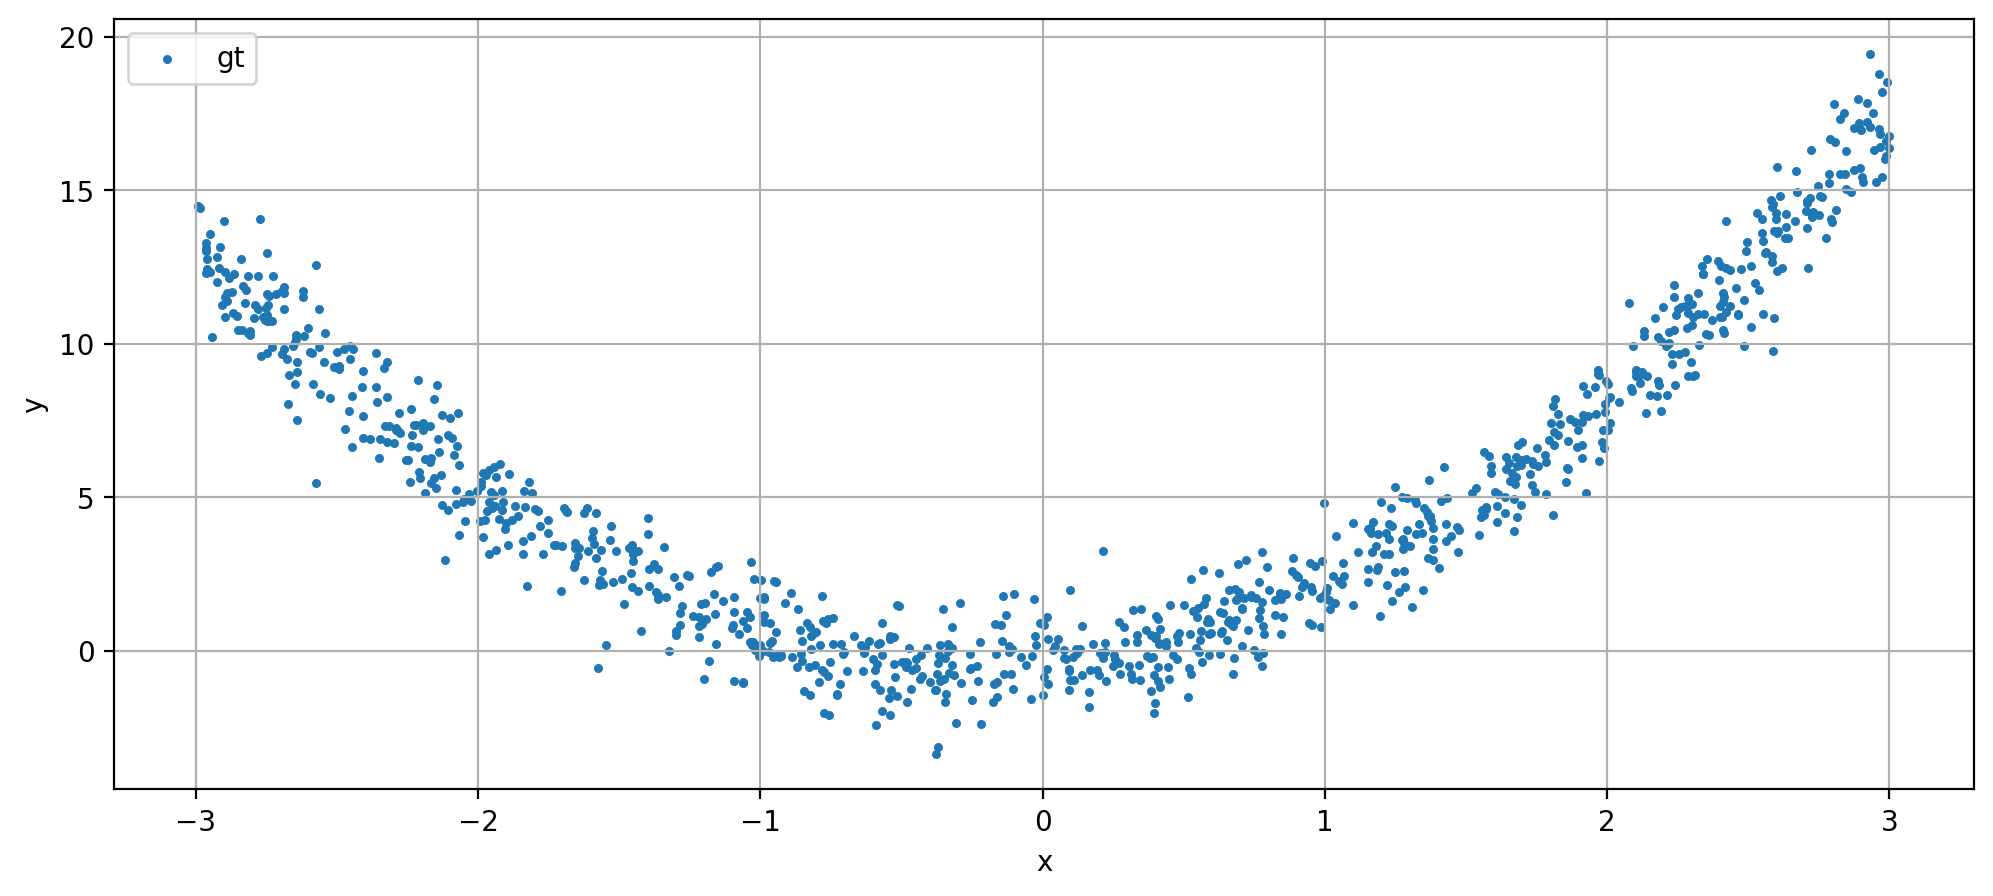

In [15]:
np.random.seed(1234)
_a = np.random.uniform(1, 5)
_b = np.random.uniform(-3, 3)
_c = np.random.uniform(-3, 3)

num_samples = 1000

xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs**2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, xs, ys):
        super().__init__()

        if len(xs) != len(ys):
            raise ValueError(f"lens mismatch: {len(xs)} != {len(ys)}")

        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, i):
        return (self.xs[i], self.ys[i])

    @staticmethod
    def collate_fn(items_list):
        xs = torch.zeros(len(items_list), 1)
        ys = torch.zeros(len(items_list), 1)

        for i, (x, y) in enumerate(items_list):
            xs[i] = x
            ys[i] = y

        return xs, ys

Метод `collate_fn` нужен не столько для самого датасета, сколько для оборачивания его в `DataLoader` - об этом чуть ниже.

In [17]:
dataset = CustomDataset(xs, ys)
dataset[0]

(1.712151502282615, 6.261151337822555)

In [18]:
dataset[1]

(1.6798548487128215, 6.005594456243541)

In [19]:
len(dataset)

1000

In [20]:
dataset[100]

(0.34656497056469693, -0.9502726915332733)

По датасету можно итерироваться (но вам это вряд ли будет нужно часто):

In [21]:
for x in dataset[:2]:
    print(x, x.shape)

for x in dataset[:5]:
    print(x, x.shape)

[1.7121515  1.67985485] (2,)
[6.26115134 6.00559446] (2,)
[ 1.7121515   1.67985485 -1.36444437 -1.34121447  1.81123307] (5,)
[6.26115134 6.00559446 1.70076346 3.39949397 6.69226491] (5,)


Теоретически, для обучения достаточно уже объекта типа `Dataset`. Однако, для удобства и для автоматизации процессов перемешивания данных, формирования батчей и использования многопоточности есть удобный класс `DataLoader`:

In [22]:
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=dataset.collate_fn)

"Длина" даталоадера - это количество батчей:

In [23]:
len(dataloader)

31

К даталоадеру нельзя обращаться по индексу, но можно итерироваться по нему:

In [24]:
dataloader[0]

TypeError: 'DataLoader' object is not subscriptable

In [25]:
print([tensor.shape for tensor in next(iter(dataloader))])

[torch.Size([32, 1]), torch.Size([32, 1])]


In [26]:
for batch in dataloader:
    xs, ys = batch
    print(xs.shape, ys.shape)
    break

torch.Size([32, 1]) torch.Size([32, 1])


Как именно происходит сборка батчей, покажем, реализовав свой игрушечный даталоадер с аналогичным функционалом:

**Задание**:
Реализовать метод `__getitem__(self, i)`, который должен возвращать i-й батч. 
* Батч должен быть списком с числом элементов = равным числу элементов, возвращаемых датасетом при обращении по индексу (обычно 2 - данные и лейблы, но есть варианты).
    * Каждый из элементов содержит не отдельный объект, а склеенный из отдельных объектов тензов
    * Длина каждого = `batch_size`
* Для сборки батча из отдельных элементов датасета используйте метод `self.dataset.collate_fn`

In [27]:
class MyDataLoader:
    def __init__(self, dataset, batch_size, collate_fn):
        self.dataset = dataset
        self.batch_size = batch_size
        self.collate_fn = collate_fn

        self.indices = np.arange(len(dataset))

    def __len__(self):
        return len(dataset) // self.batch_size

    def __getitem__(self, i):
        # YOUR CODE HERE

        # indices = ...
        # items = ...
        # batch = ...
        indices = self.indices[self.batch_size * i : self.batch_size * (i + 1)]
        items = [self.dataset[i] for i in indices]
        batch = self.collate_fn(items)

        # END OF YOUR CODE

        return batch

In [28]:
my_dataloader = MyDataLoader(dataset, batch_size=32, collate_fn=dataset.collate_fn)

In [29]:
batch = my_dataloader[0]

assert len(batch) == 2
assert batch[0].shape == (32, 1)
assert batch[1].shape == (32, 1)

Про параметры `DataLoader`-а, которые мы сегодня не трогали (`pin_memory`, `num_workers`, ...), поговорим в другой раз.

### 1.2. Модель: `nn.Module`

Нейросетевые модели состоят из слоев, которые применяются ко входу (обычно) последовательно.
Каждый слой должен быть наследником `nn.Module`, чтобы сам pytorch понимал: перед ним слой нейросети, у него есть параметры, его надо уметь дифференцировать, и т.д.

In [30]:
import torch.nn as nn

**Задание:**
Реализовать недостающие куски кода в методах `__init__()` и `forward()`.
* В `__init__()` должны быть инициализированы матрица `self.weights` (`out_dim x in_dim`) и вектор `bias` (или `None`).
* В `forward()` они должны быть применены ко входу `x` (`batch x in_dim`).

**NB**: Помните, что обычно обработка данных моделью происходит по батчам, т.е. даже если на вход придет 1 объект, у него будет размерность (`batch x in_dim`).

В чём принципиальное отличие `nn.Module` от `autograd.Function`? ООП и переиспользование функций с реализованным дифференцированием.

In [31]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()

        # YOUR CODE HERE

        # self.weight = ...
        # self.bias = ...
        self.weight = nn.Parameter(torch.randn(out_features, in_features) / in_features)
        self.bias = nn.Parameter(torch.randn(out_features) / in_features)

        # END OF YOUR CODE

    def forward(self, x):
        # YOUR CODE HERE

        # output = ...
        output = x @ self.weight.T + self.bias

        # END OF YOUR CODE

        return output

    def __repr__(self):
        return f"CustomLinear({self.weight.shape[1]}, {self.weight.shape[0]}, bias={self.bias is not None})"

In [32]:
linear = CustomLinear(8, 1)

assert isinstance(linear.weight, nn.Parameter)
assert isinstance(linear.bias, nn.Parameter)
assert linear.weight.shape == (1, 8)
assert linear.bias.shape == (1,)

In [33]:
print(linear)

CustomLinear(8, 1, bias=True)


In [34]:
dir(nn.Module)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'call_super_init',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'get_buffer',
 'get_e

Посмотрим, какие атрибуты и методы есть у нашего класса при наследовании от `nn.Module`.

Во-первых, доступ к обучаемым (и не только) параметрам:

In [35]:
for p in linear.parameters():
    print(p)
    print()

Parameter containing:
tensor([[ 0.2200,  0.0818,  0.0686,  0.0459,  0.0152,  0.0808, -0.1771,  0.1054]],
       requires_grad=True)

Parameter containing:
tensor([-0.0788], requires_grad=True)



In [36]:
for p in linear.named_parameters():
    print(p)
    print()

('weight', Parameter containing:
tensor([[ 0.2200,  0.0818,  0.0686,  0.0459,  0.0152,  0.0808, -0.1771,  0.1054]],
       requires_grad=True))

('bias', Parameter containing:
tensor([-0.0788], requires_grad=True))



In [37]:
linear.state_dict()

OrderedDict([('weight',
              tensor([[ 0.2200,  0.0818,  0.0686,  0.0459,  0.0152,  0.0808, -0.1771,  0.1054]])),
             ('bias', tensor([-0.0788]))])

Для удобства чтения и отладки, часто полезно определить dunder-метод `__repr__` для информативного вывода самого объекта:

In [38]:
print(linear)

CustomLinear(8, 1, bias=True)


Важными полями являются индикатор `.training`: он показывает, в каком режиме находится модель - обучения или инференса.

**Вопрос**: зачем?

In [39]:
linear.training

True

In [40]:
linear.eval()
linear.training

False

In [41]:
linear.train()
linear.training

True

**NB**: Выход из режима `training` не отключает вычисление градиентов!

Как мы уже говорили в прошлый раз, вычисления можно производить не только в одиночной точности; для этого необходимо (но не всегда достаточно) привести все веса к соответствующему типу. Наследование от класса `nn.Module` позволяет сделать это одной командой:

In [42]:
linear.weight.dtype

torch.float32

In [43]:
linear = linear.half()

In [44]:
linear.weight.dtype

torch.float16

In [45]:
linear = linear.float()

In [46]:
linear.weight.dtype

torch.float32

А вот что pytorch из коробки делать не позволяет, так это узнать, на каком устройстве лежит наша модель:

In [47]:
# device = torch.device("cpu")
device = torch.device("mps")

In [48]:
linear = linear.to(device)

In [49]:
linear.device

AttributeError: 'CustomLinear' object has no attribute 'device'

In [50]:
linear.weight.device

device(type='mps', index=0)

In [51]:
next(linear.parameters()).device

device(type='mps', index=0)

In [52]:
device = torch.device("cpu")

In [53]:
linear = linear.to(device)

Теперь попробуем собственно применить нашу модель:

In [54]:
x = torch.randn(32, 8)

In [55]:
y = linear(x)
y.shape

torch.Size([32, 1])

In [56]:
x = torch.randn(32, 9)
y = linear(x)
y.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x9 and 8x1)

### 1.3. Рутина: все остальное

#### 1.3.1. Оптимизатор

In [57]:
import torch.optim as optim

In [58]:
optimizer = optim.SGD(linear.parameters(), lr=1e-4)

In [59]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [60]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[ 0.2201,  0.0818,  0.0686,  0.0459,  0.0152,  0.0808, -0.1771,  0.1053]],
          requires_grad=True),
   Parameter containing:
   tensor([-0.0789], requires_grad=True)],
  'lr': 0.0001,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False}]

#### 1.3.2. Лосс

Можно написать самому:

In [61]:
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [62]:
xs, ys_true = next(iter(dataloader))

In [63]:
ys_pred = torch.randn_like(ys_true)

In [64]:
mse_loss(ys_true, ys_pred)

tensor(75.5377)

Можно использовать готовые:

In [65]:
from torch.nn.functional import mse_loss as torch_mse_loss

In [66]:
torch_mse_loss(ys_true, ys_pred)

tensor(75.5377)

#### 1.3.3. Рутина обучения

**Задание:** Дописать функцию для обучения.
* Получение предсказаний моделью для объектов из батча
* Подсчет лосса
* Обновление весов по вызова backprop

In [67]:
def train_epoch(model, dataloader, optimizer, loss_fn, epoch):
    model.train()

    losses = []
    for batch in dataloader:
        xs, ys_true = batch
        xs = xs.to(device)
        ys_true = ys_true.to(device)

        # YOUR CODE HERE

        # ys_pred = ...
        # loss = ...
        # ...
        # ...
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # END OF YOUR CODE

        losses.append(loss.item())

    return np.mean(losses)

На валидации будем еще и сохранять результат предсказаний - для визуализации:

In [68]:
def val_epoch(model, dataloader, loss_fn):
    model.eval()

    losses = []
    preds = []
    for batch in dataloader:
        xs, ys_true = batch
        xs = xs.to(device)
        ys_true = ys_true.to(device)
        with torch.no_grad():
            ys_pred = model(xs)

        loss = loss_fn(ys_pred, ys_true)
        losses.append(loss.item())

        preds.append(ys_pred.detach().cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    return np.mean(losses), preds

## 2. Учим

### 2.1. Baseline

Начнем с обучения 1 полносвязного слоя, по сути - аппроксимируем данные прямой.

In [69]:
import tqdm

In [70]:
num_epochs = 128
lr = 8e-4
batch_size = 8

train_size = 800

In [71]:
xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs**2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

train_dataset = CustomDataset(xs[:train_size], ys[:train_size])
val_dataset = CustomDataset(xs[train_size:], ys[train_size:])

In [72]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True
)

val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=train_dataset.collate_fn, drop_last=False
)

In [73]:
device = torch.device("cpu")

In [74]:
model = CustomLinear(1, 1).to(device)

In [75]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [76]:
loss_fn = mse_loss

In [77]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [00:01<00:00, 69.67it/s]


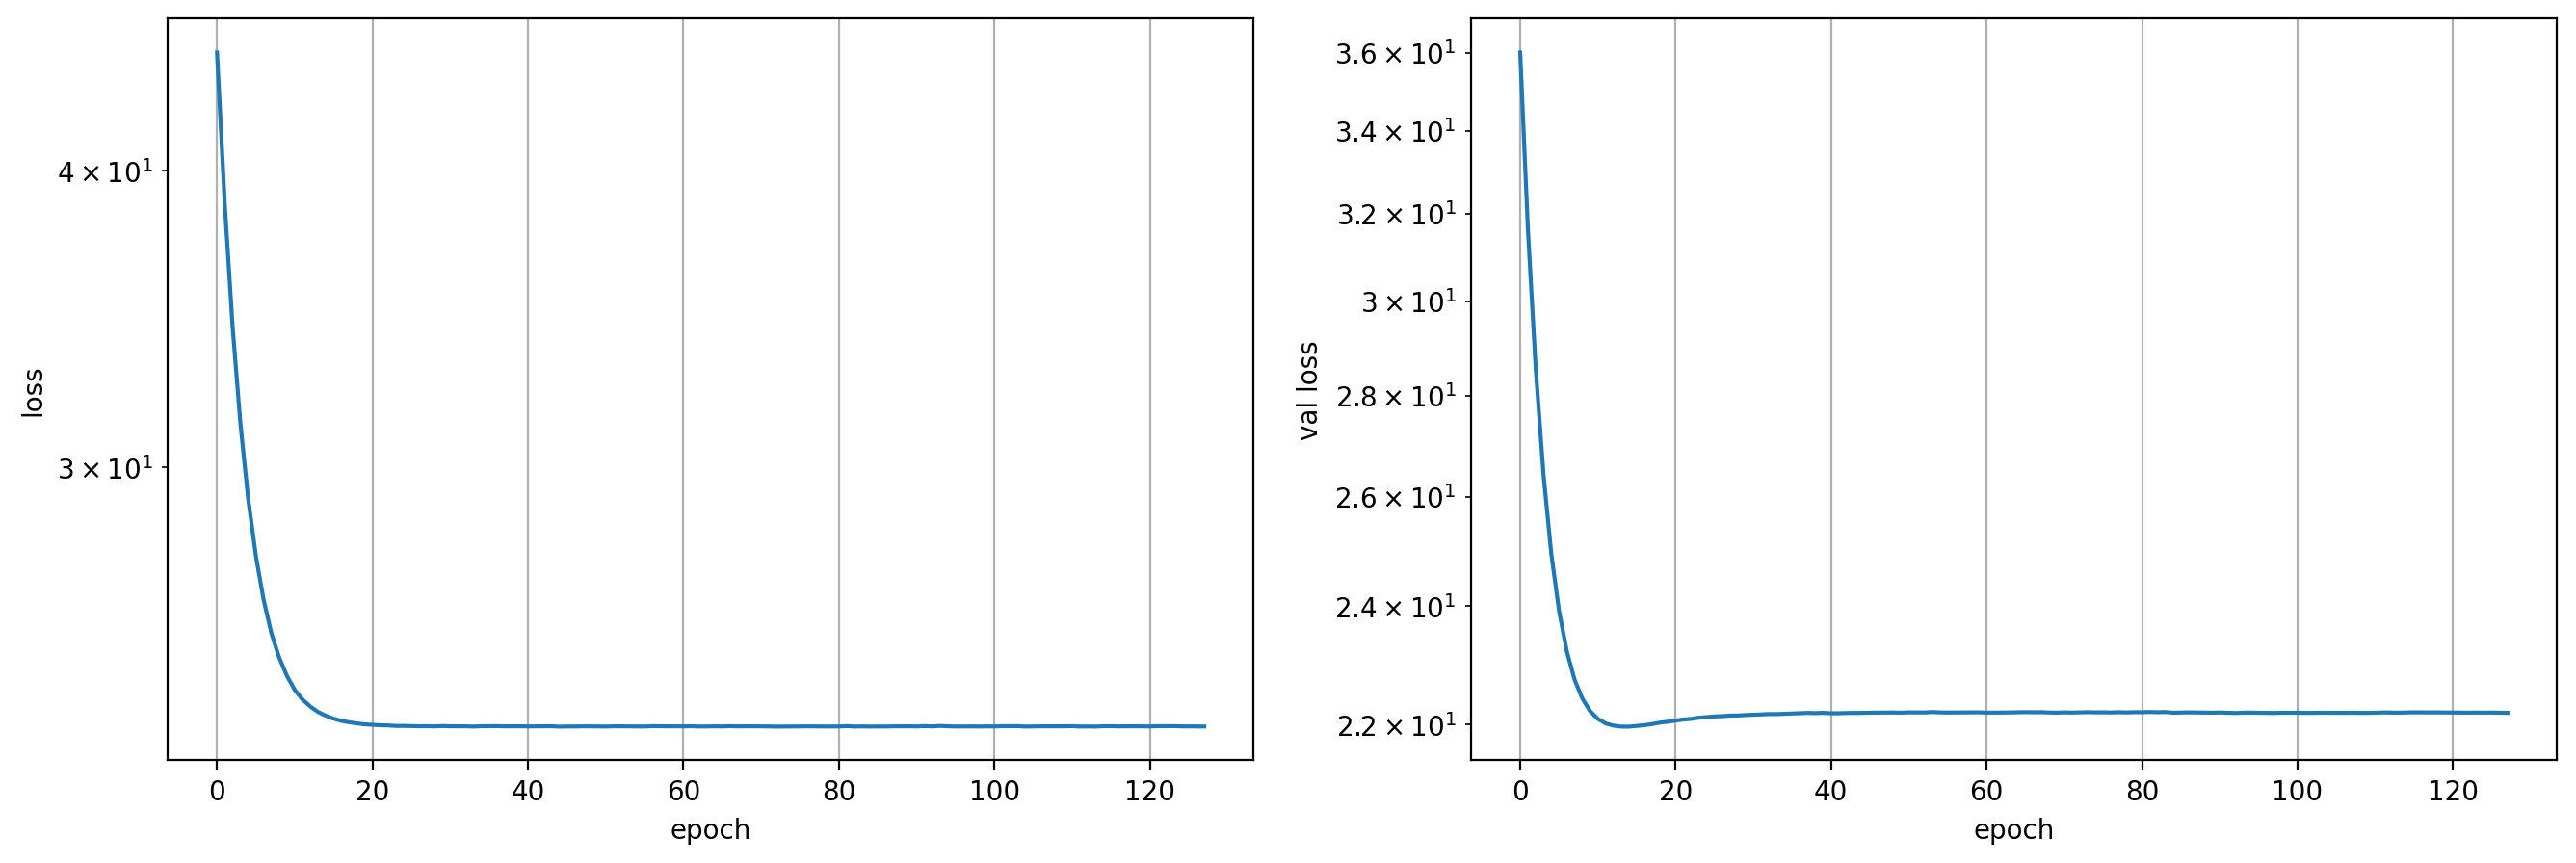

In [78]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(losses)
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.semilogy(val_losses)
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

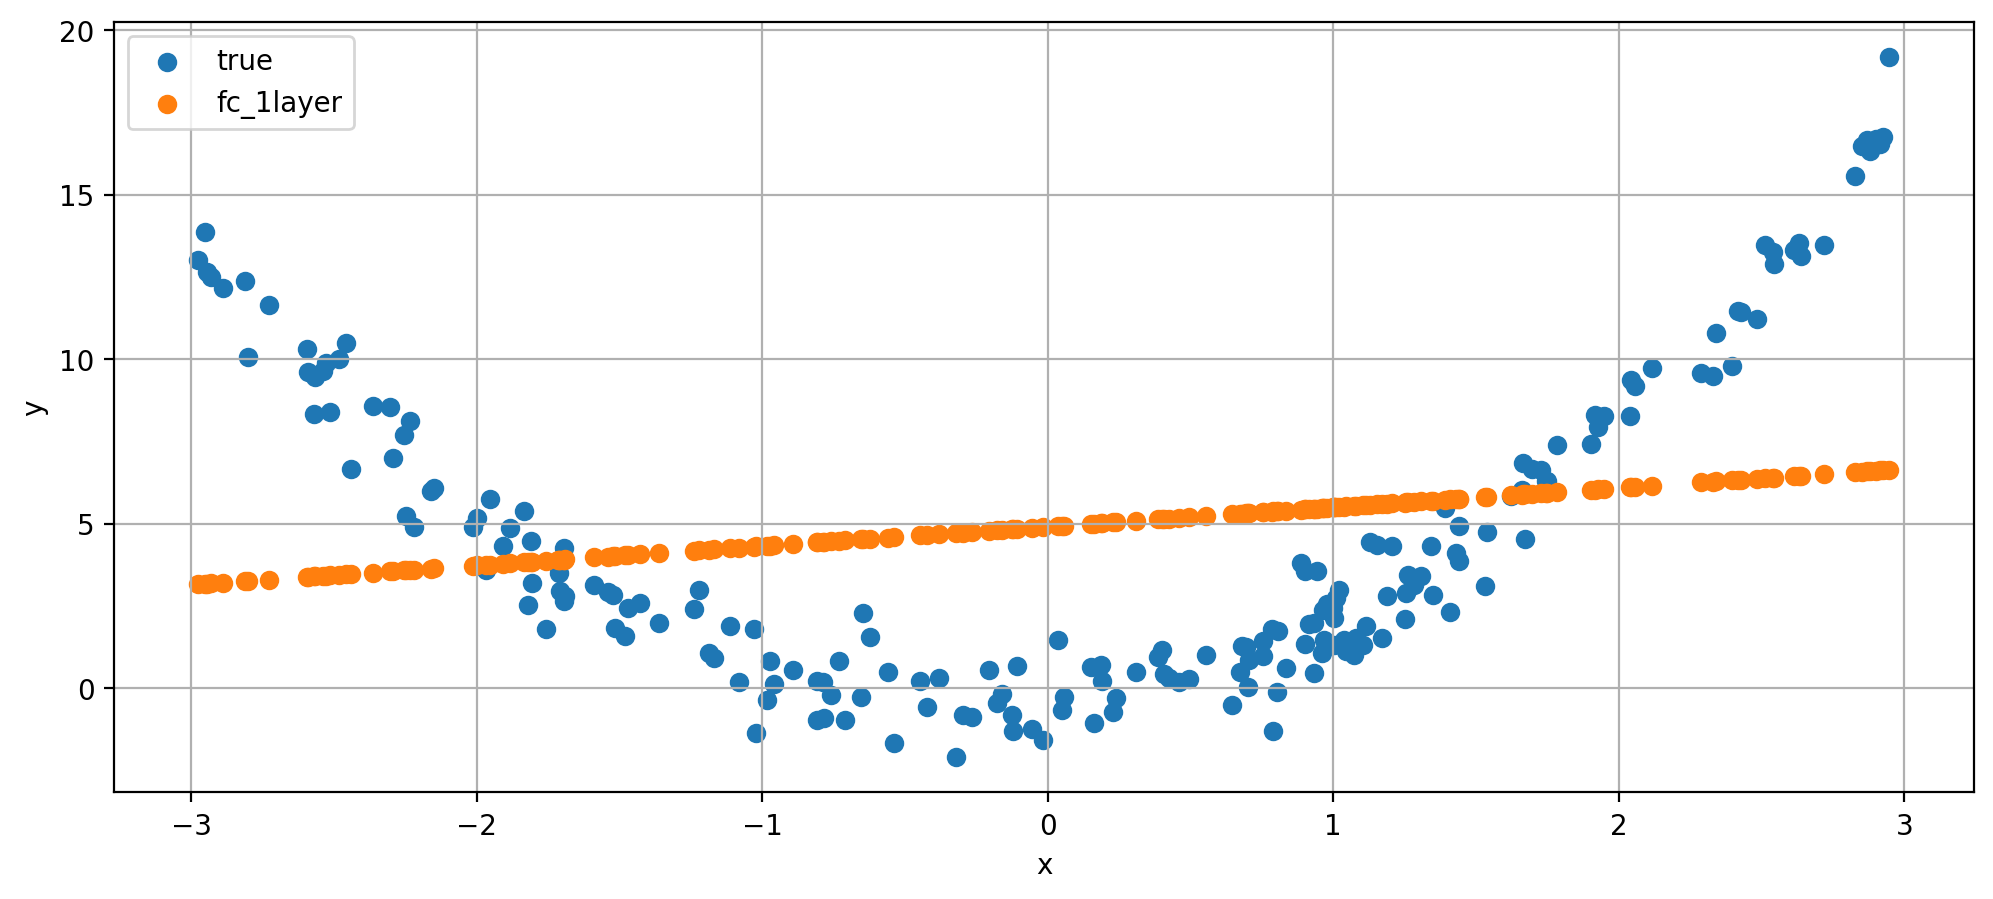

In [79]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], val_preds[-1], label="fc_1layer")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [80]:
fc_1layer_train_losses = losses
fc_1layer_val_losses = val_losses
fc_1layer_preds = preds

### 2.2. Stack more layers

In [81]:
from torch.nn import Sequential
from torch.nn import ReLU

**Задание**: соберите сеть из двух полносвязных слоев размерами (1, 4) и (4, 1); добавьте между слоями нелинейность ReLU.

In [82]:
# YOUR CODE HERE

layers = [CustomLinear(1, 4), ReLU(inplace=True), CustomLinear(4, 1)]
model = nn.Sequential(*layers)

# END OF YOUR CODE

model

Sequential(
  (0): CustomLinear(1, 4, bias=True)
  (1): ReLU(inplace=True)
  (2): CustomLinear(4, 1, bias=True)
)

In [83]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [84]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

  5%|▍         | 6/128 [00:00<00:02, 52.62it/s]

100%|██████████| 128/128 [00:02<00:00, 53.23it/s]


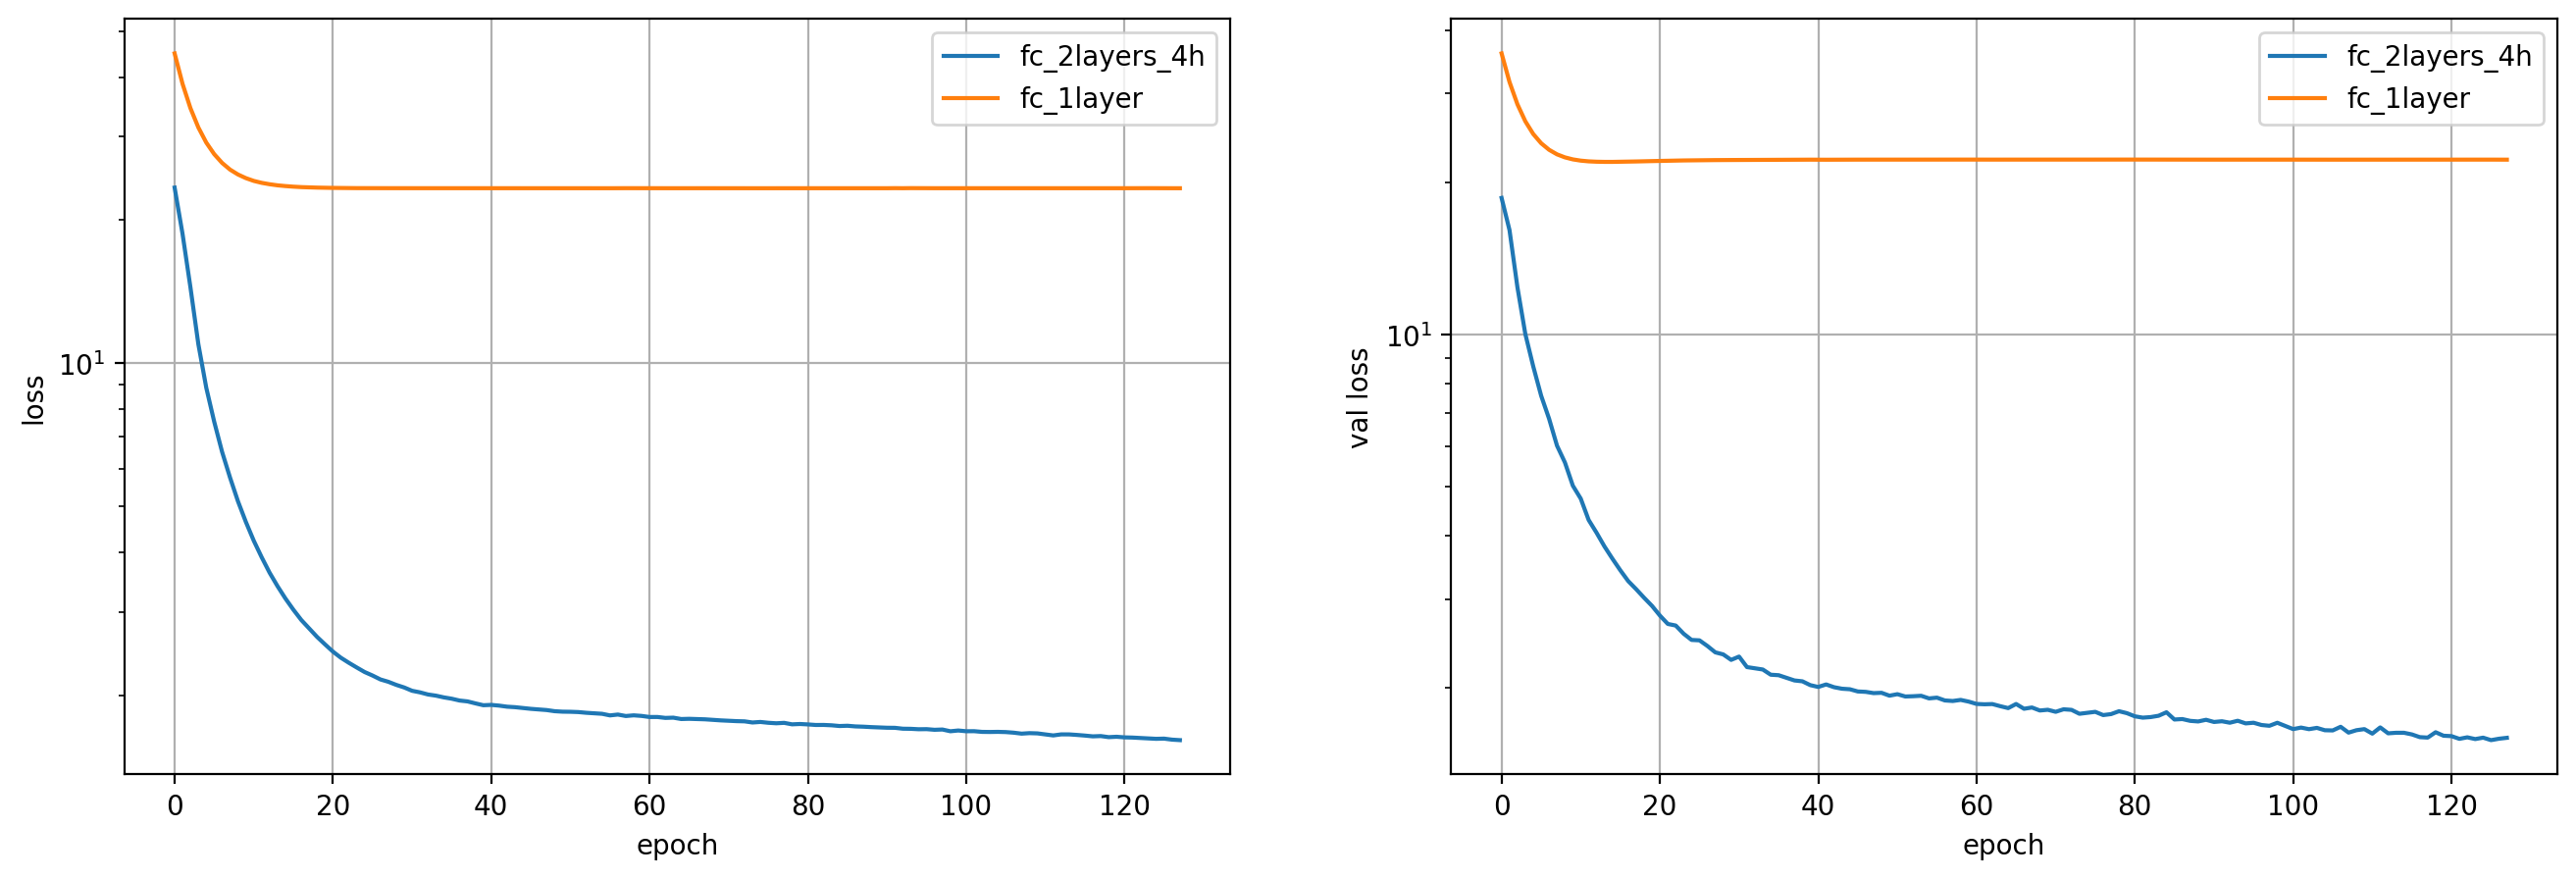

In [85]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(losses, label="fc_2layers_4h")
plt.semilogy(fc_1layer_train_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.semilogy(val_losses, label="fc_2layers_4h")
plt.semilogy(fc_1layer_val_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

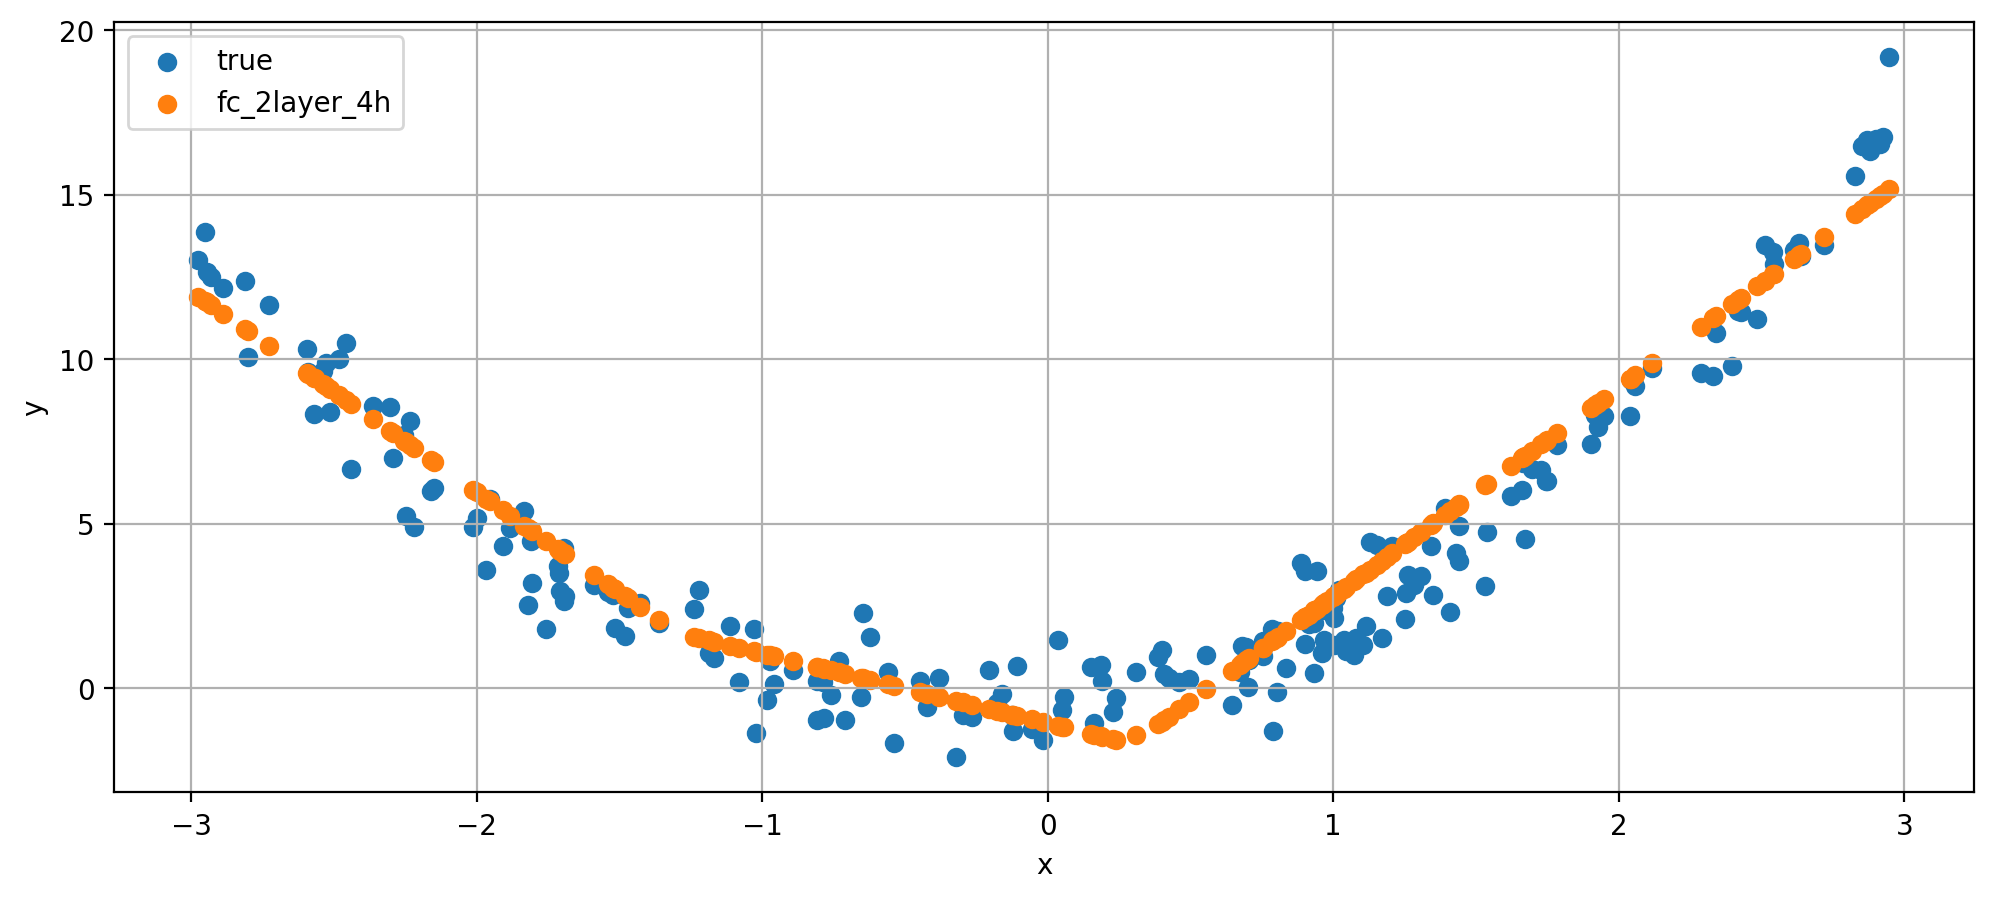

In [86]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], val_preds[-1], label="fc_2layer_4h")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [87]:
fc_2layer_4h_train_losses = losses
fc_2layer_4h_val_losses = val_losses
fc_2layer_4h_preds = preds

Добавим нейронов в скрытый слой:

In [88]:
layers = [CustomLinear(1, 16), ReLU(inplace=True), CustomLinear(16, 1)]

model = Sequential(*layers)
model

Sequential(
  (0): CustomLinear(1, 16, bias=True)
  (1): ReLU(inplace=True)
  (2): CustomLinear(16, 1, bias=True)
)

In [89]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [90]:
losses = []
val_losses = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)

  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [00:02<00:00, 54.72it/s]


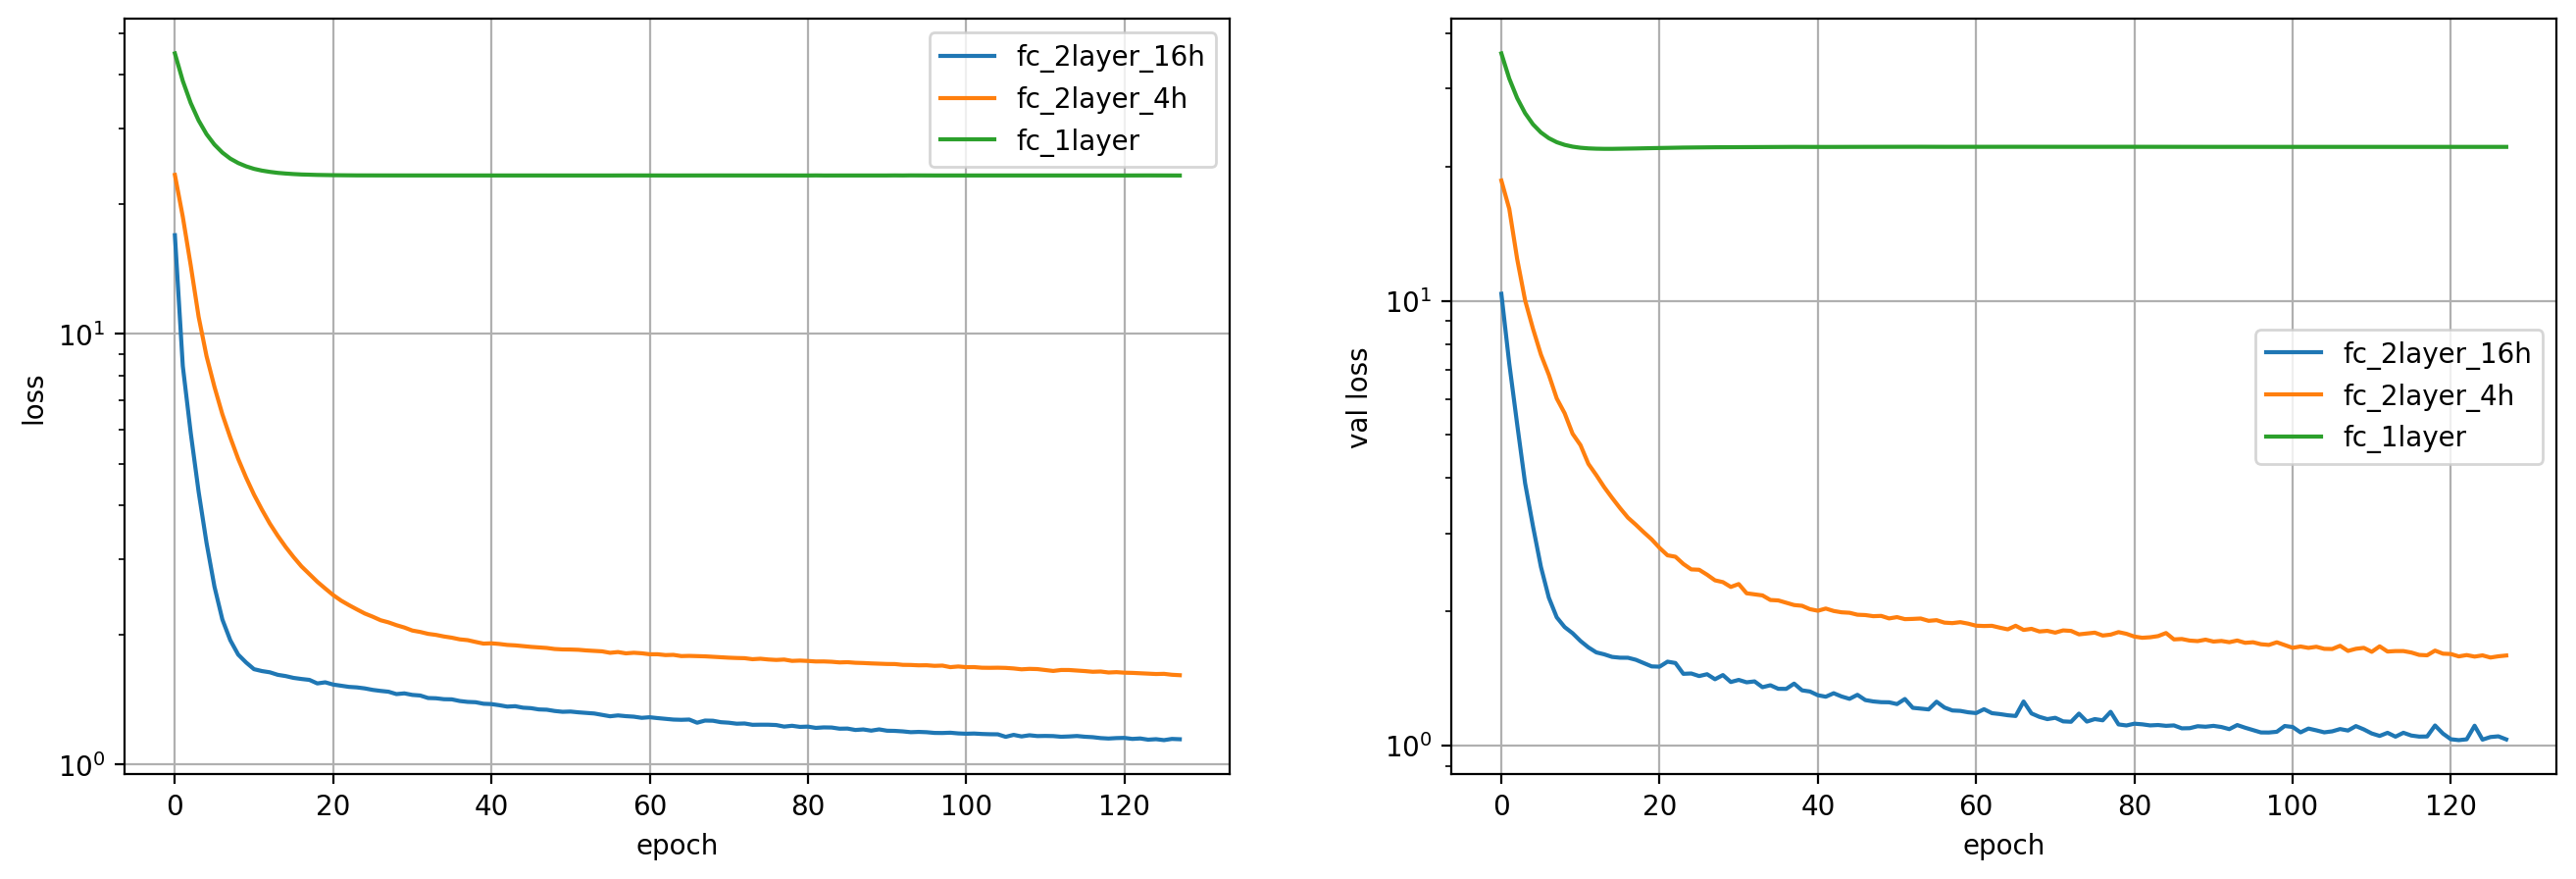

In [91]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(losses, label="fc_2layer_16h")
plt.semilogy(fc_2layer_4h_train_losses, label="fc_2layer_4h")
plt.semilogy(fc_1layer_train_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.semilogy(val_losses, label="fc_2layer_16h")
plt.semilogy(fc_2layer_4h_val_losses, label="fc_2layer_4h")
plt.semilogy(fc_1layer_val_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

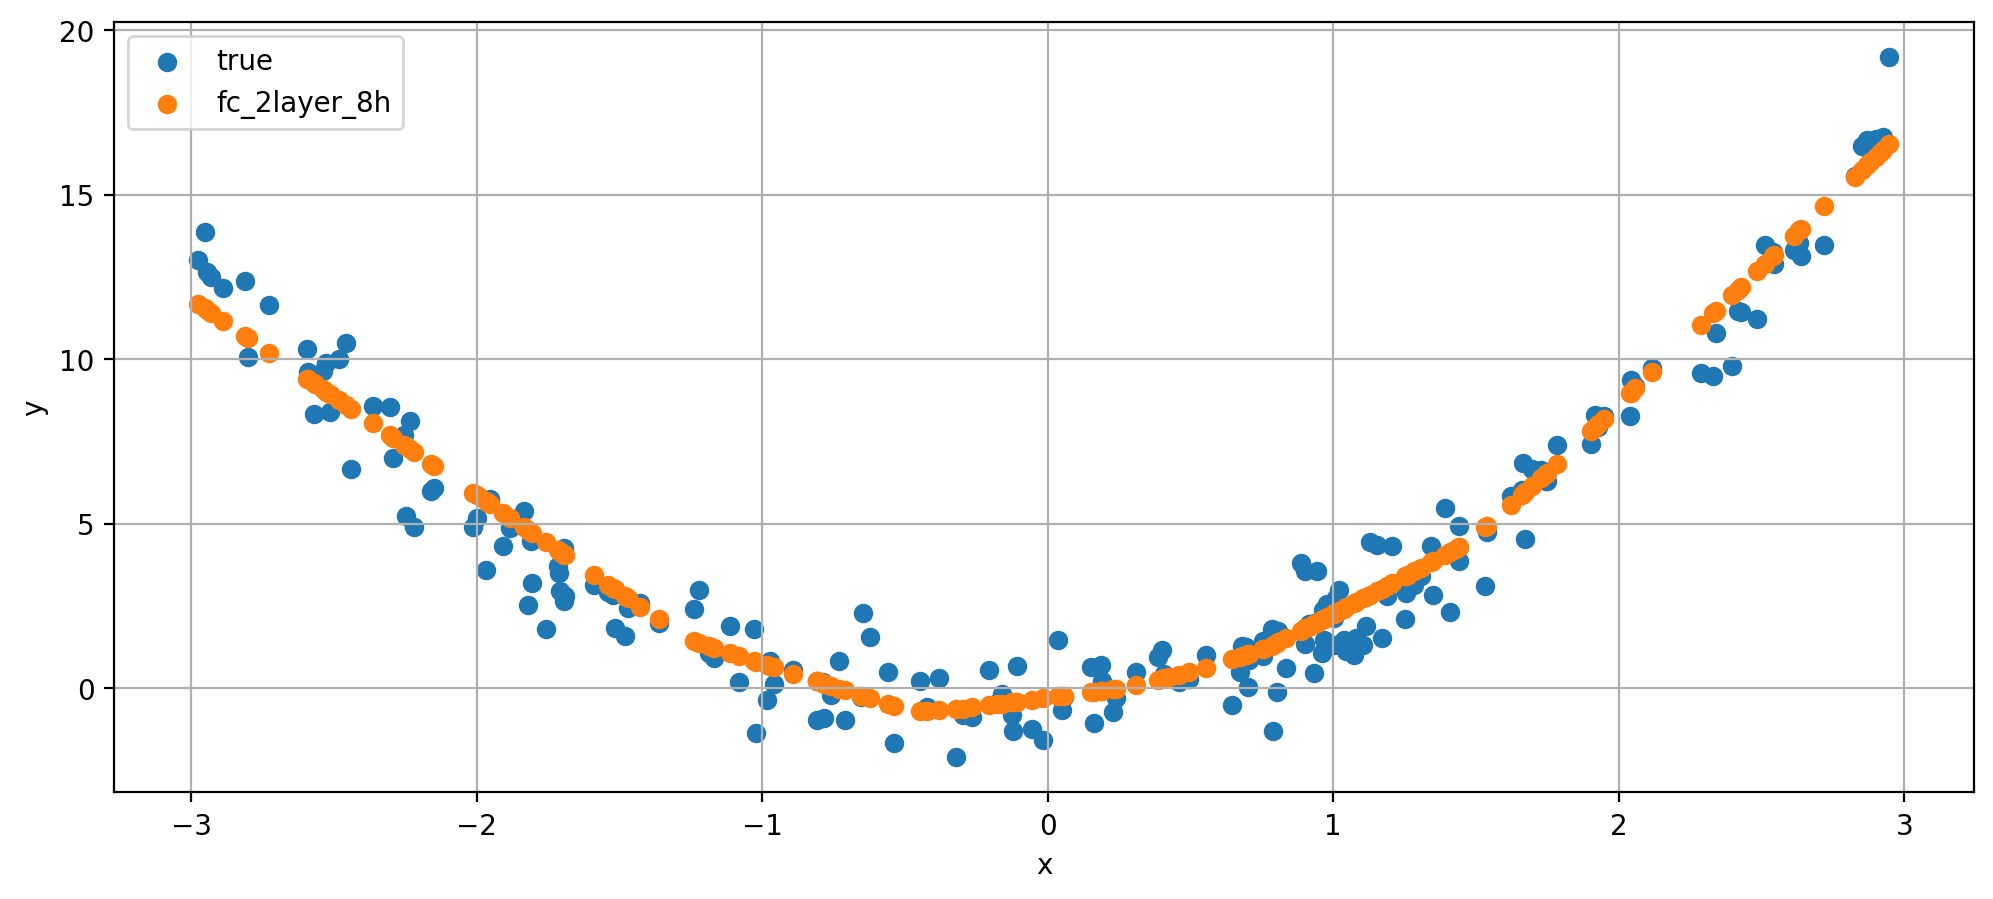

In [92]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], preds, label="fc_2layer_8h")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Видимо, что наша модель ведет себя как кусочно-линейная функция. Любопытные визуализации на эту тему можно найти, например, [здесь](http://neuralnetworksanddeeplearning.com/chap4.htmlhttp://neuralnetworksanddeeplearning.com/chap4.html).

**Пища для размышлений:** данные были сгенерированы с использованием всего лишь трех неизвестных параметров (a, b, c). Они полностью, не считая случайного шума, определяют поведение целевой функции. Нам же потребовалось значительно больше параметров (сколько, кстати?), чтобы кое-как аппроксимировать данные с помощью полносвязной сети. Почему это так? Можно ли с этим что-то сделать?
См. [Yarotsky Bound](https://arxiv.org/abs/1610.01145) как ответ на вопрос об оптимальной аппроксимации квадратичной функции и семейство теорем об универсальной [аппроксимации](https://mitliagkas.github.io/ift6085-2020/ift-6085-lecture-10-notes.pdf).

## 3. I/O

Обученные веса модели хорошо бы уметь сохранять и загружать для дальнейшего использования.

In [93]:
print(model)

Sequential(
  (0): CustomLinear(1, 16, bias=True)
  (1): ReLU(inplace=True)
  (2): CustomLinear(16, 1, bias=True)
)


В Pytorch сохранение и загрузка весов выполняется через `state_dict` модели:

In [94]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-1.1821],
        [-0.1436],
        [ 0.4285],
        [-1.0024],
        [ 0.8344],
        [ 1.5084],
        [-2.1232],
        [ 0.3231],
        [ 1.3622],
        [ 1.2777],
        [-0.0202],
        [ 2.4509],
        [ 0.4060],
        [ 0.4928],
        [ 0.6134],
        [-0.0738]])), ('0.bias', tensor([ 0.3200, -0.5020, -0.4883,  0.5365, -1.4526, -2.2224, -1.0138,  0.0549,
        -1.0557,  0.3819, -0.1490,  3.0841,  1.3669, -0.7380,  2.3289,  1.6013])), ('2.weight', tensor([[ 0.8346,  0.0466,  0.4984,  0.7378,  0.8793,  1.7353,  1.5689,  0.1589,
          1.1997,  0.4196,  0.0656,  1.2844, -0.7442,  0.6119, -1.0412, -0.6865]])), ('2.bias', tensor([-0.5517]))])


### 3.1. Save

In [95]:
output_fn = "./state_dict.pth.tar"

In [96]:
with open(output_fn, "wb") as fp:
    torch.save(model.state_dict(), fp)

### 3.2. Load

In [97]:
model = Sequential(CustomLinear(1, 16), ReLU(inplace=True), CustomLinear(16, 1))

In [98]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.8489],
        [ 0.5886],
        [ 0.0913],
        [ 0.3242],
        [ 0.1015],
        [-0.4882],
        [ 0.7044],
        [-2.0261],
        [ 0.5845],
        [ 0.1806],
        [ 0.1796],
        [-0.1194],
        [-0.1238],
        [-0.9568],
        [ 1.0546],
        [-1.1485]])), ('0.bias', tensor([-0.8139,  0.2953,  0.8897, -1.6690,  0.9409,  2.9895, -1.3344, -1.8486,
        -0.0817, -1.6305, -1.0991, -0.8467, -0.5101,  1.5037,  0.4683,  0.9954])), ('2.weight', tensor([[ 0.0683,  0.0797, -0.0331, -0.0168, -0.0978, -0.0177, -0.0242, -0.1062,
         -0.0212,  0.0467, -0.0502, -0.0594, -0.0646, -0.0288,  0.0658, -0.0684]])), ('2.bias', tensor([0.1310]))])


In [99]:
with open(output_fn, "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu")
state_dict

OrderedDict([('0.weight',
              tensor([[-1.1821],
                      [-0.1436],
                      [ 0.4285],
                      [-1.0024],
                      [ 0.8344],
                      [ 1.5084],
                      [-2.1232],
                      [ 0.3231],
                      [ 1.3622],
                      [ 1.2777],
                      [-0.0202],
                      [ 2.4509],
                      [ 0.4060],
                      [ 0.4928],
                      [ 0.6134],
                      [-0.0738]])),
             ('0.bias',
              tensor([ 0.3200, -0.5020, -0.4883,  0.5365, -1.4526, -2.2224, -1.0138,  0.0549,
                      -1.0557,  0.3819, -0.1490,  3.0841,  1.3669, -0.7380,  2.3289,  1.6013])),
             ('2.weight',
              tensor([[ 0.8346,  0.0466,  0.4984,  0.7378,  0.8793,  1.7353,  1.5689,  0.1589,
                        1.1997,  0.4196,  0.0656,  1.2844, -0.7442,  0.6119, -1.0412, -0.6865]])),
        

In [100]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [101]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-1.1821],
                      [-0.1436],
                      [ 0.4285],
                      [-1.0024],
                      [ 0.8344],
                      [ 1.5084],
                      [-2.1232],
                      [ 0.3231],
                      [ 1.3622],
                      [ 1.2777],
                      [-0.0202],
                      [ 2.4509],
                      [ 0.4060],
                      [ 0.4928],
                      [ 0.6134],
                      [-0.0738]])),
             ('0.bias',
              tensor([ 0.3200, -0.5020, -0.4883,  0.5365, -1.4526, -2.2224, -1.0138,  0.0549,
                      -1.0557,  0.3819, -0.1490,  3.0841,  1.3669, -0.7380,  2.3289,  1.6013])),
             ('2.weight',
              tensor([[ 0.8346,  0.0466,  0.4984,  0.7378,  0.8793,  1.7353,  1.5689,  0.1589,
                        1.1997,  0.4196,  0.0656,  1.2844, -0.7442,  0.6119, -1.0412, -0.6865]])),
        

Помимо непосредственно весов, бывает полезно сохранить и состояние других объектов: например, оптимизатора (чтобы продолжить обучении с той же точки):

In [102]:
def save_checkpoint(model, optimizer, output_fn):
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}

    with open(output_fn, "wb") as fp:
        torch.save(checkpoint, output_fn)


def load_checkpoint(checkpoint_fn, model, optimizer):
    with open(checkpoint_fn, "rb") as fp:
        checkpoint = torch.load(fp, map_location="cpu")

    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [103]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
optimizer.param_groups[0]["lr"] = 1e-10
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-10
    maximize: False
    weight_decay: 0
)

In [104]:
checkpoint_fn = "./checkpoint.pth.tar"

In [105]:
save_checkpoint(model, optimizer, checkpoint_fn)

In [106]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [107]:
load_checkpoint(checkpoint_fn, model, optimizer)

In [108]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-10
    maximize: False
    weight_decay: 0
)

## 4. Пример с картинками: MNIST

Обучения на MNIST в курсе DL почти не избежать...

In [109]:
import os
import glob
import matplotlib.pyplot as plt

In [110]:
#!pip install opencv-python

In [111]:
import cv2

MNIST - это ставший классикой датасет с изображениями рукописных цифр. На нем мы построим минимальный пример работы с изображениями.

Вообще он есть в `torchvision.datasets.MNIST`, но сегодня для наглядности мы обработаем его самописным классом.

In [112]:
import torchvision

?torchvision.datasets.MNIST

Init signature:
torchvision.datasets.MNIST(
    root: str,
    train: bool = True,
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    download: bool = False,
) -> None
Docstring:     
`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

Args:
    root (string): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
        and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
    train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
        otherwise from ``t10k-images-idx3-ubyte``.
    download (bool, optional): If True, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not
        downloaded again.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in t

In [113]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar -xzf mnist_png.tar.gz
!ls mnist_png/

testing  training


В отличие от датасета, рассмотренного в начале семинара, здесь мы будем передавать не непосредственно данные, а путь до папки с файлами; причем структуру мы считаем известной (`split/digit/*.png`).

In [129]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir):
        self.images_filenames = []
        self.class_labels = []
        for class_label in os.listdir(root_dir):
            for image_basename in os.listdir(os.path.join(root_dir, class_label)):
                if not image_basename.endswith(".png"):
                    continue
                image_filename = os.path.join(root_dir, class_label, image_basename)
                self.images_filenames.append(image_filename)
                self.class_labels.append(int(class_label))

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, i):
        image = cv2.imread(self.images_filenames[i], cv2.IMREAD_GRAYSCALE)
        label = self.class_labels[i]
        return image, label

    @staticmethod
    def collate_fn(items):
        images = []
        labels = []
        for image, label in items:
            image = image / 255.0
            images.append(image.ravel())
            labels.append(label)
        return torch.tensor(np.array(images)).float(), torch.tensor(np.array(labels)).long()

In [130]:
train_dataset = MNISTDataset(root_dir="mnist_png/training")
len(train_dataset)

60000

Посмотрим на сами данные из датасета:

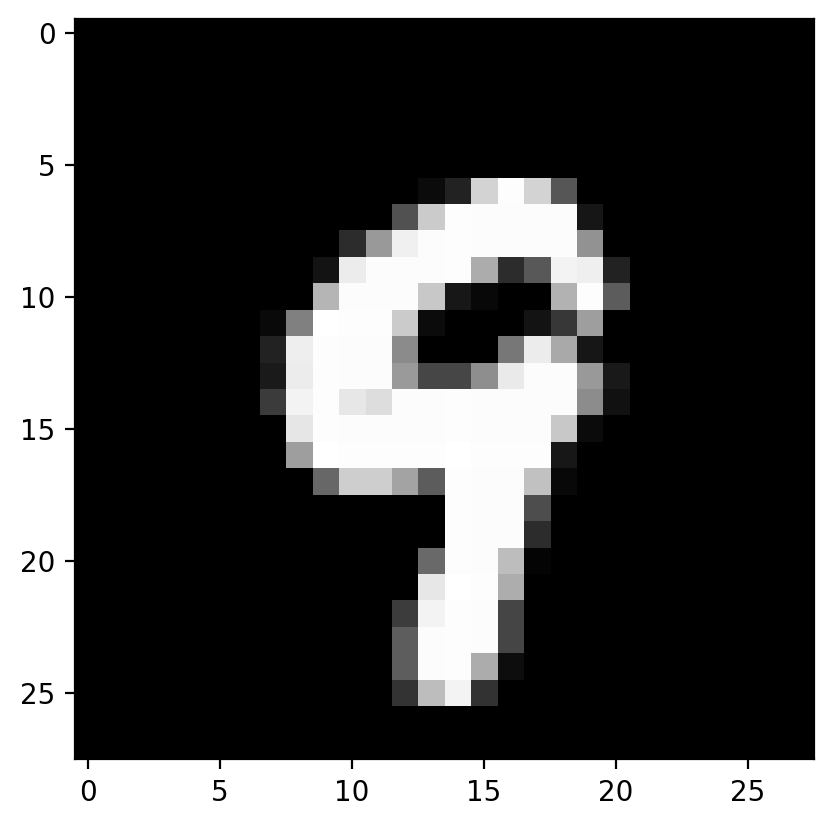

In [131]:
image, label = train_dataset[0]
plt.imshow(image, cmap="gray")
plt.show()

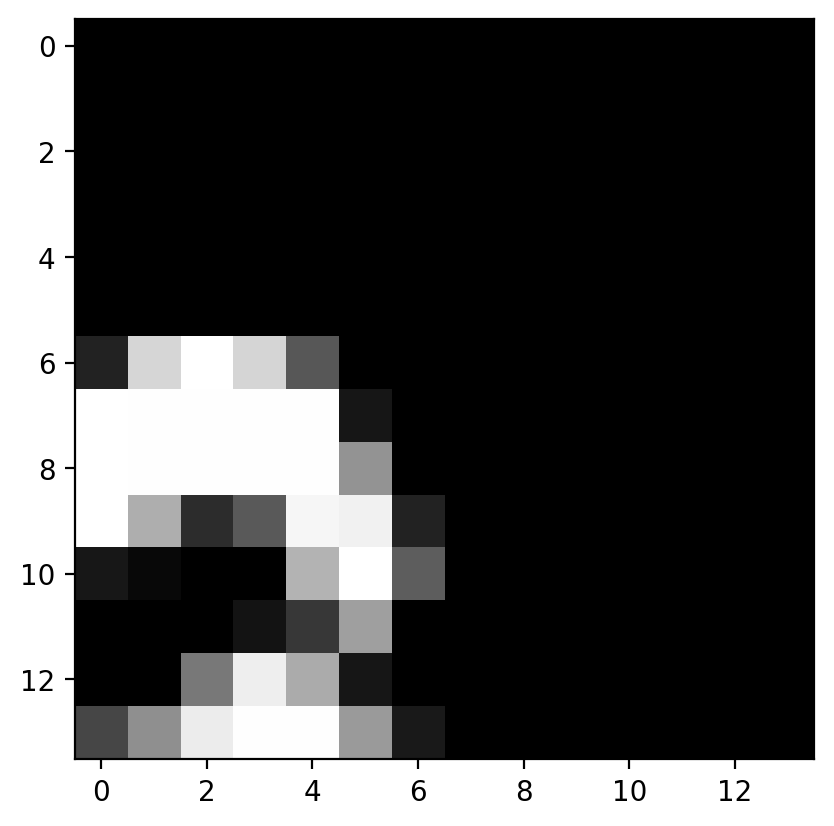

In [132]:
plt.imshow(image[:14, -14:], cmap="gray")

Вспомогательная функция для массовой визуализации:

In [133]:
def show_images_with_captions(images, captions=None, ncol=8):
    nrow = len(images) // ncol

    plt.figure(figsize=(16, 16 * nrow // ncol))
    for i in range(len(images)):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(images[i], cmap="gray")
        if captions is not None:
            plt.title(captions[i])
        plt.grid(False)
        plt.axis(False)
    plt.show()

In [134]:
sample_indices = np.random.choice(len(train_dataset), size=64, replace=False)

sample_images = []
sample_captions = []
for i in sample_indices:
    image, label = train_dataset[i]
    sample_images.append(image)
    sample_captions.append(f"gt: {label}")

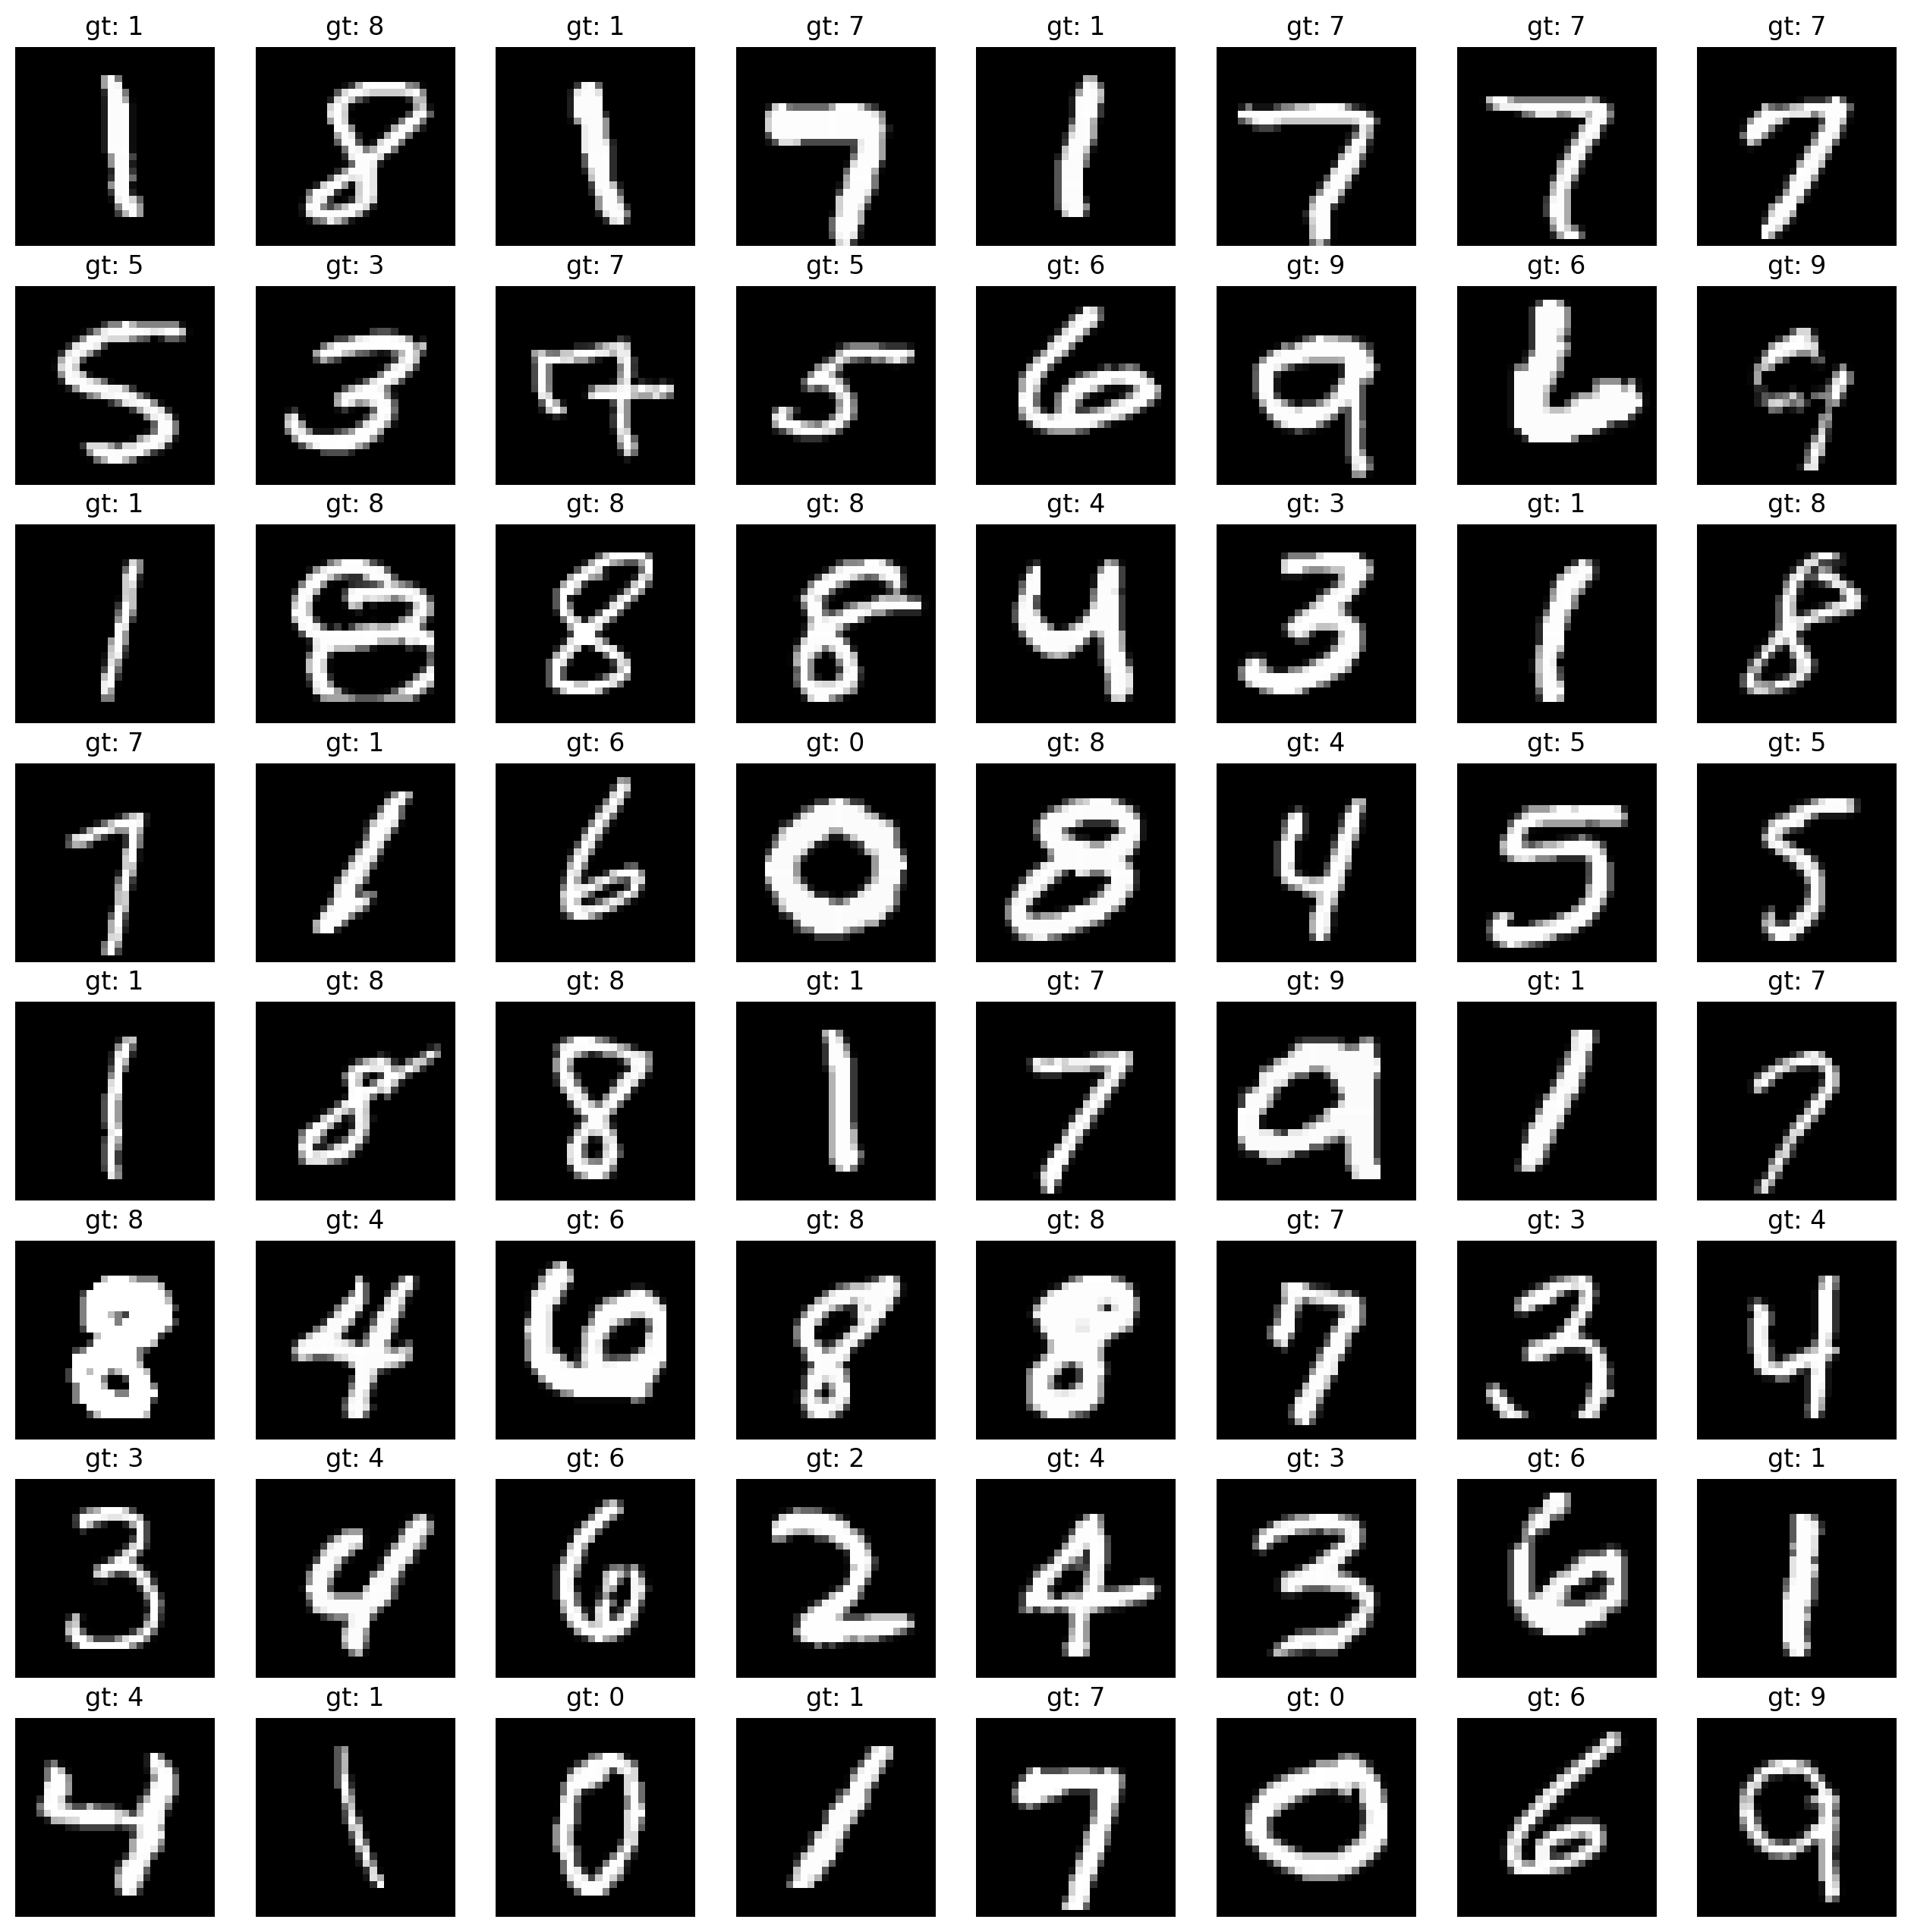

In [135]:
show_images_with_captions(sample_images, sample_captions)

Зарядим теперь обучение сети чуть глубже (3 слоя), да еще и с BatchNorm1d:

In [136]:
num_epochs = 5
batch_size = 100
lr = 3e-4

# device = torch.device("cpu")
device = torch.device("mps")
# device = torch.device("cuda:0")

In [137]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_dataset.collate_fn
)

val_dataset = MNISTDataset(root_dir="mnist_png/testing/")
val_dataloader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=train_dataset.collate_fn
)

Если успеем :) При желании напишите дома с прототипом, как в оригинальном `nn.BatchNorm1d`, мы оценим.

$$
\text{BN}(x) = \gamma * \frac{x - \mathbb{E}[x]}{\sqrt{\text{Var}[x] + \epsilon}} + \beta \\ 
\hat{x} = (1 - \mu) \times \hat{x} + \mu \times \mathbb{E}[x]
$$

In [163]:
class CustomBatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()

        shape = (1, num_features)
        self.eps = eps
        self.momentum = momentum

        # YOUR CODE HERE

        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))

        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

        # END OF YOUR CODE

    def forward(self, x):
        moving_mean = self.moving_mean.to(x.device)
        moving_var = self.moving_var.to(x.device)

        # YOUR CODE HERE

        # output = ...

        if not self.training:
            x_hat = (x - moving_mean) / torch.sqrt(moving_var + self.eps)
        else:
            mean = x.mean(dim=0)
            var = ((x - mean) ** 2).mean(dim=0)
            x_hat = (x - mean) / torch.sqrt(var + self.eps)
            self.moving_mean = (1.0 - self.momentum) * moving_mean + self.momentum * mean
            self.moving_var = (1.0 - self.momentum) * moving_var + self.momentum * var
        output = self.gamma * x_hat + self.beta

        # END OF YOUR CODE

        return output

    def __repr__(self):
        return f"CustomBatchNorm1d({self.gamma.shape}, bias={self.beta is not None})"

In [166]:
model = Sequential(
    CustomLinear(28 * 28, 512),
    CustomBatchNorm1d(512),
    ReLU(inplace=True),
    CustomLinear(512, 1024),
    CustomBatchNorm1d(1024),
    ReLU(inplace=True),
    CustomLinear(1024, 10),
).to(device)

In [167]:
optimizer = optim.Adam(model.parameters(), lr=lr)

Лосс возьмем готовый, свой напишете дома:

In [168]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()

Функции для обучения / валидации возьмем те же, что и раньше - пока сгодятся:

In [169]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:20<00:00, 16.10s/it]


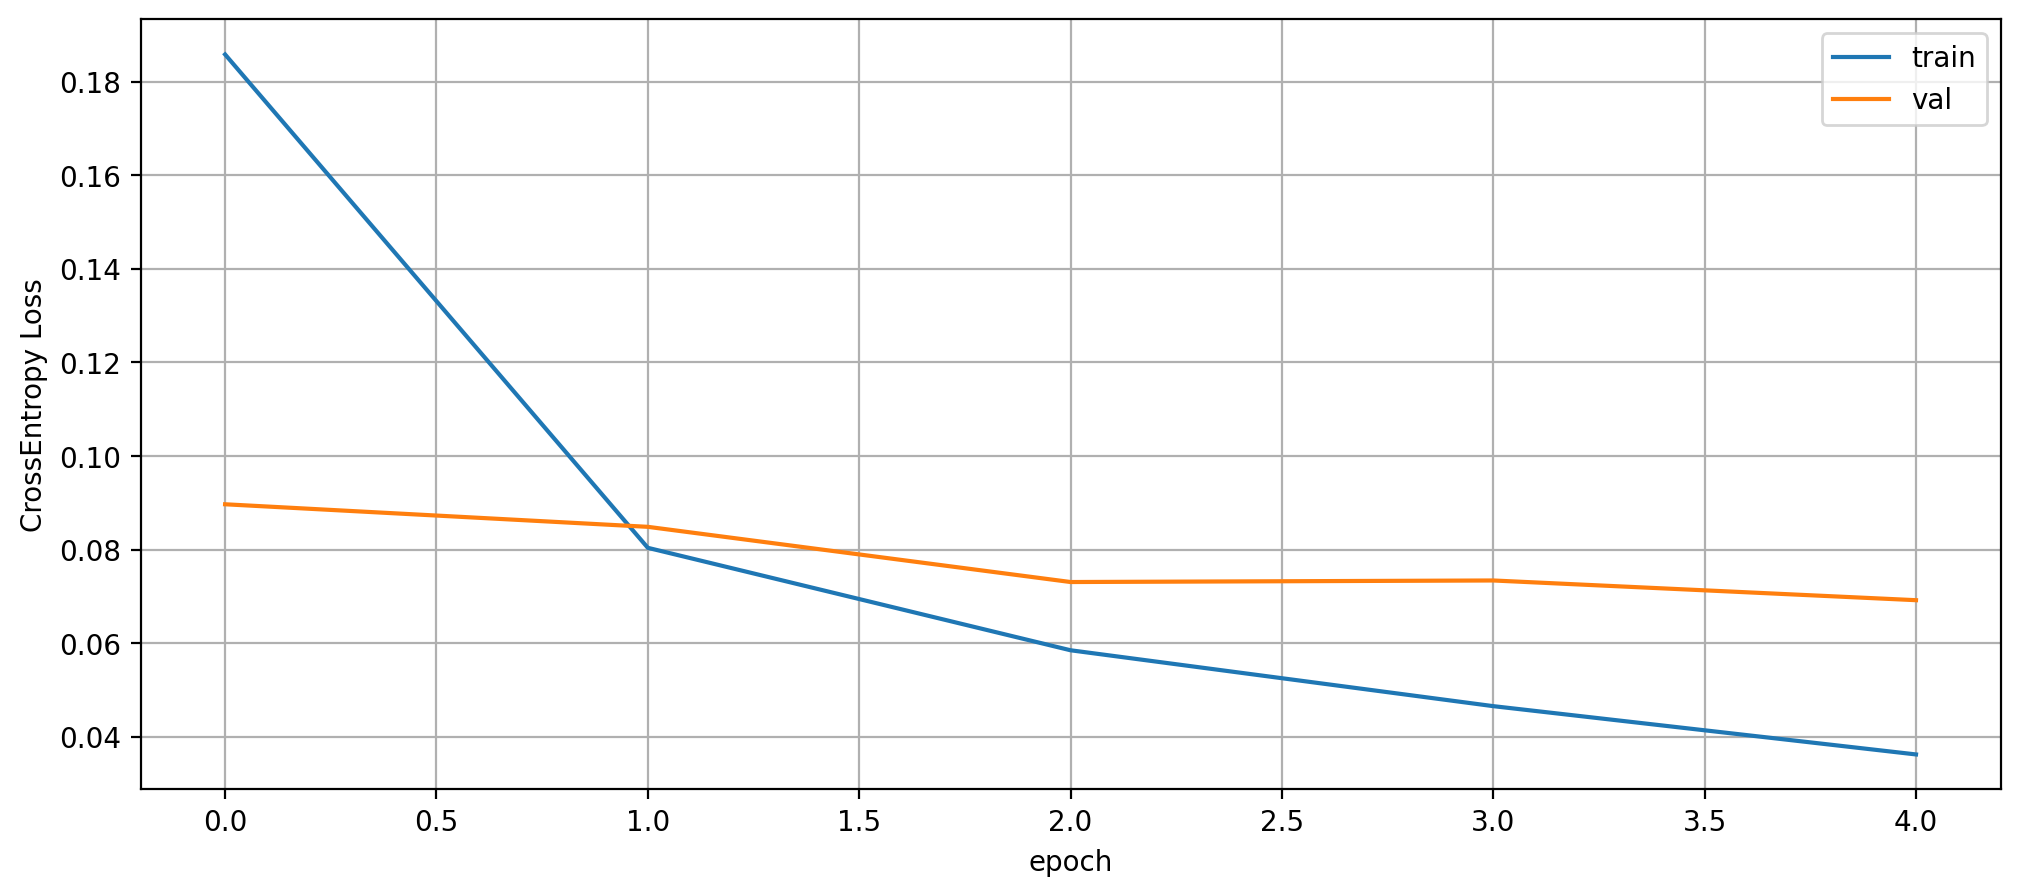

In [170]:
plt.figure(figsize=(12, 5))
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.grid()
plt.show()

Соберем все предсказания / gt-лейблы, чтобы посчитать метрику Accuracy и сделать визуализацию:

In [144]:
val_pred_labels = []
for val_pred in val_preds[-1]:
    pred_label = np.argmax(val_pred)
    val_pred_labels.append(pred_label)
val_pred_labels = np.asarray(val_pred_labels)

In [145]:
val_labels = []
for image, label in val_dataset:
    val_labels.append(label)
val_labels = np.asarray(val_labels)

In [146]:
acc = (val_pred_labels == val_labels).mean()
acc

0.9778

In [147]:
sample_indices = np.random.choice(len(val_dataset), size=64, replace=False)

sample_images = []
sample_captions = []
for i in sample_indices:
    image, label = val_dataset[i]
    pred_label = val_pred_labels[i]
    sample_images.append(image)
    sample_captions.append(f"gt: {label} | pred: {pred_label}")

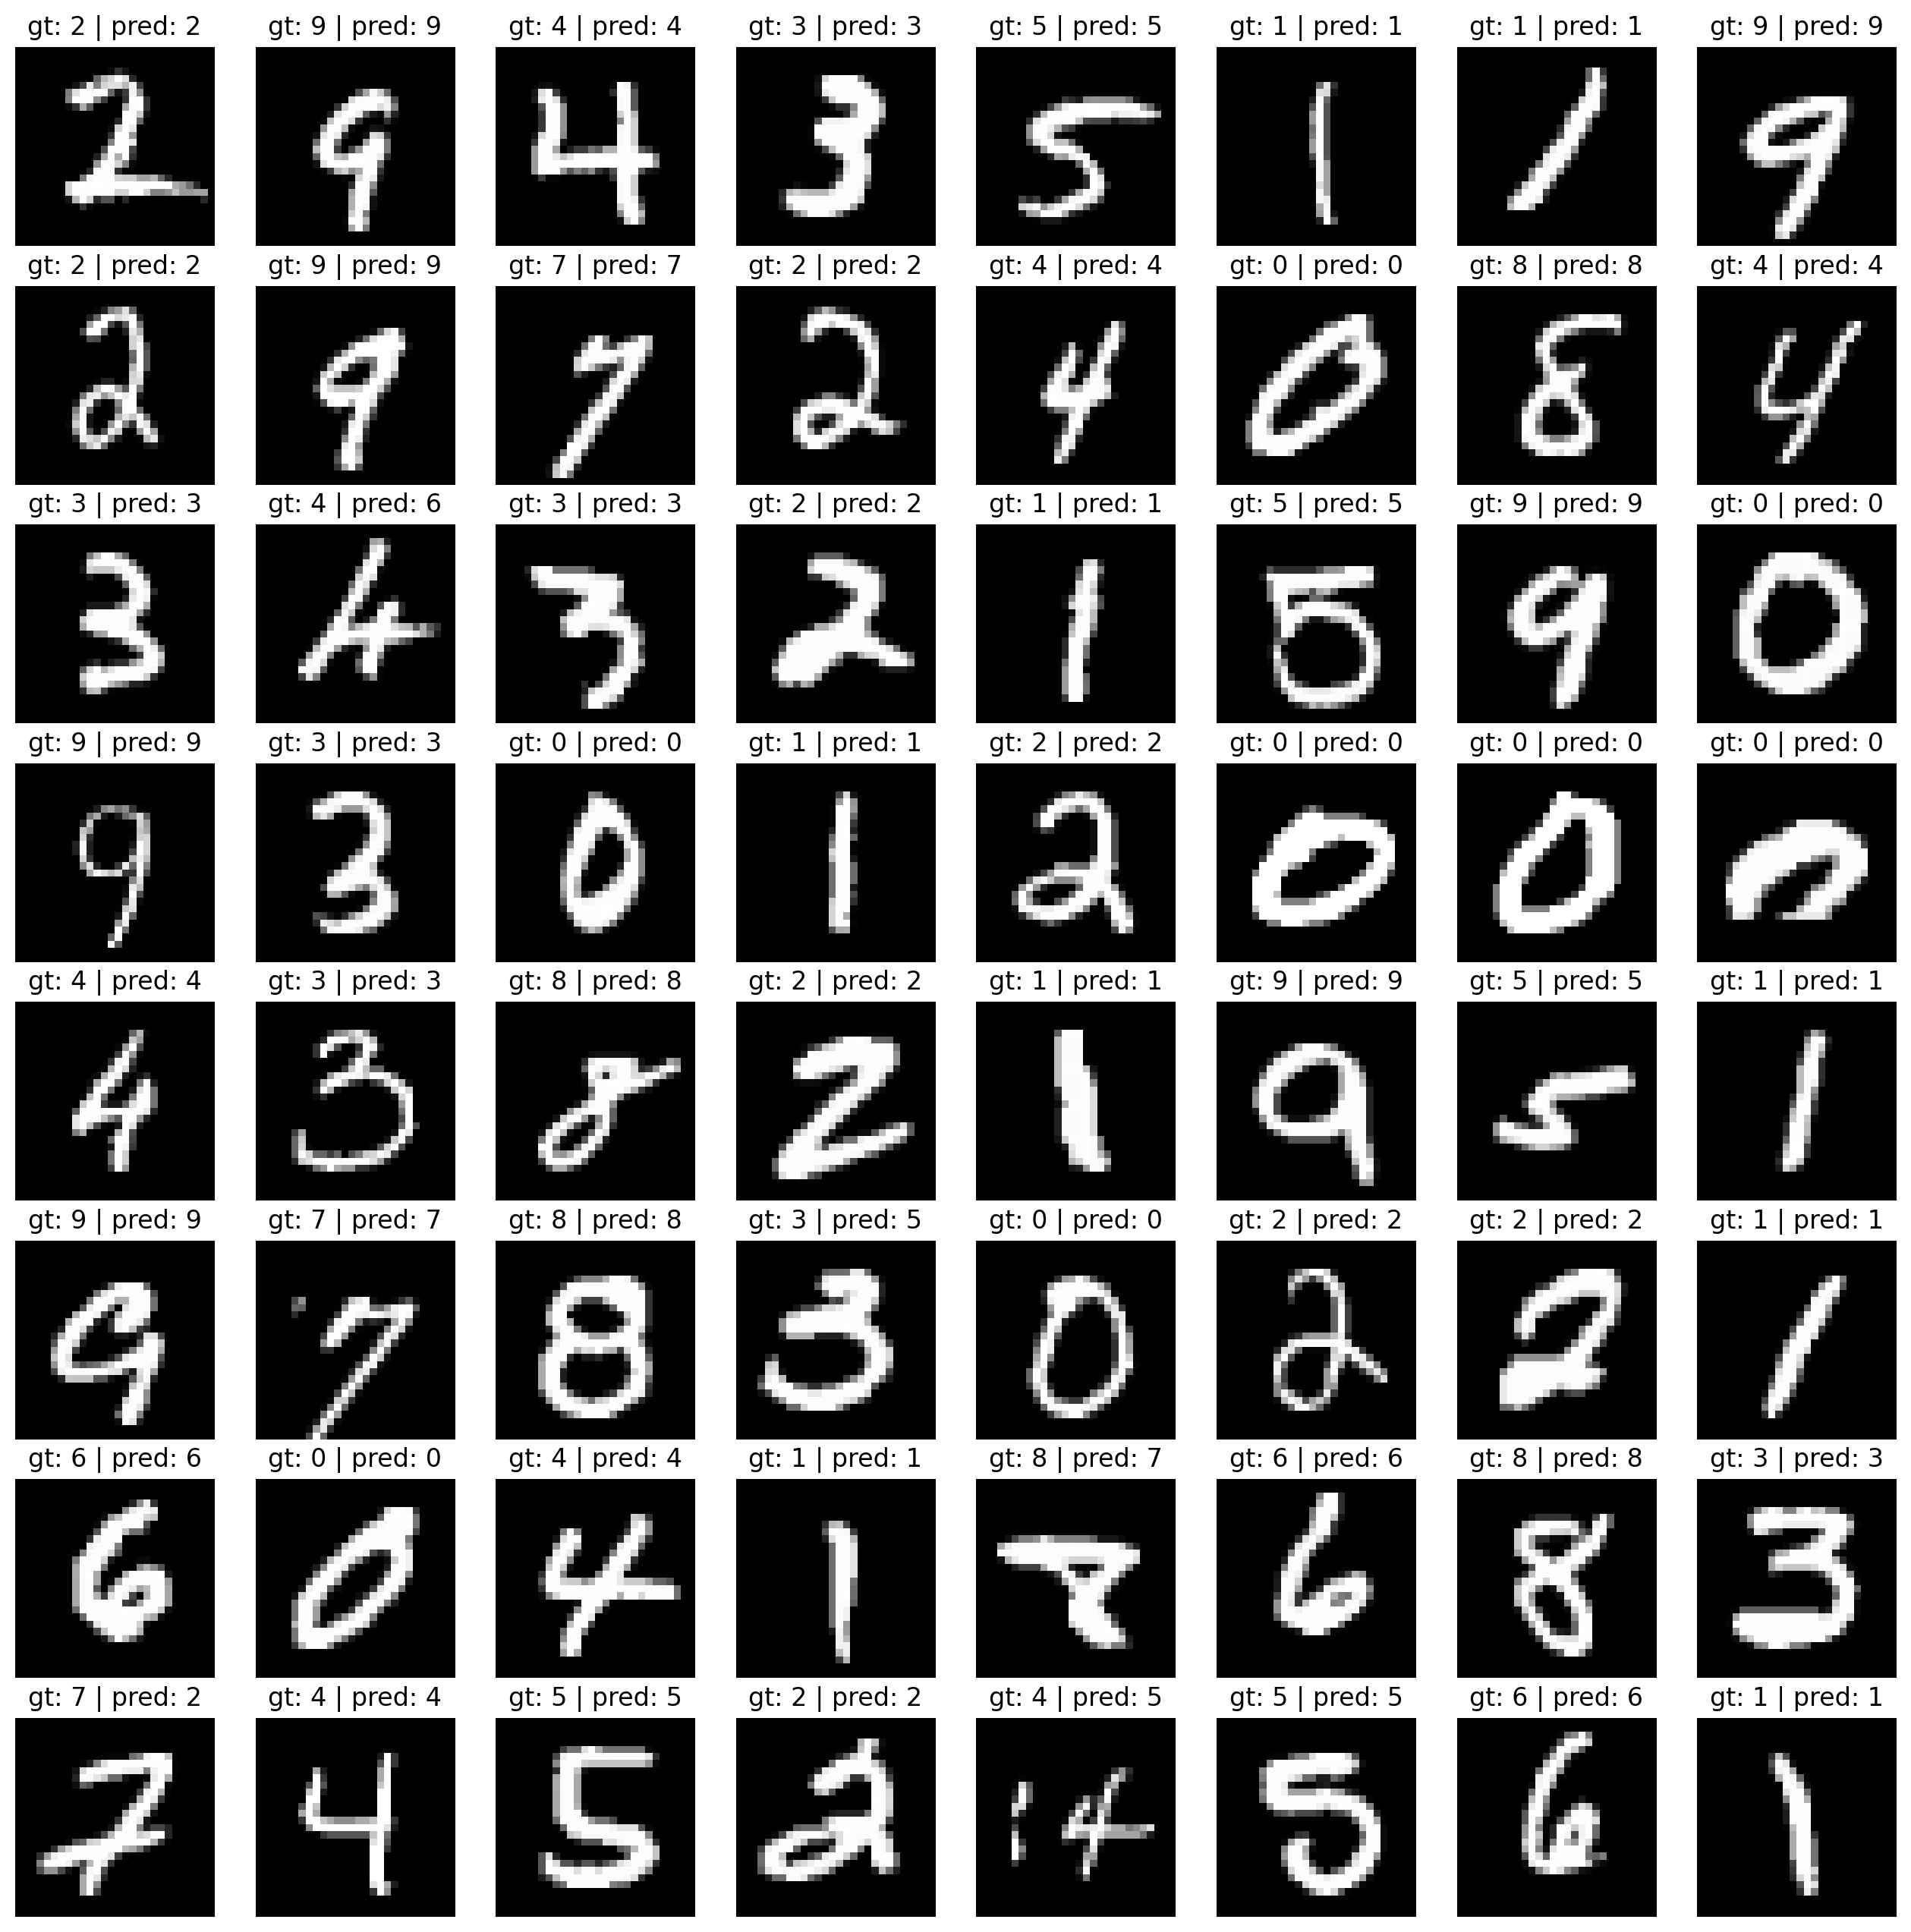

In [148]:
show_images_with_captions(sample_images, sample_captions)

Можем отдельно отрисовать те примеры из валидации, на которых модель ошибается:

In [149]:
sample_indices = np.random.choice(np.where(val_labels != val_pred_labels)[0], size=64, replace=False)

sample_images = []
sample_captions = []
for i in sample_indices:
    image, label = val_dataset[i]
    pred_label = val_pred_labels[i]
    sample_images.append(image)
    sample_captions.append(f"gt: {label} | pred: {pred_label}")

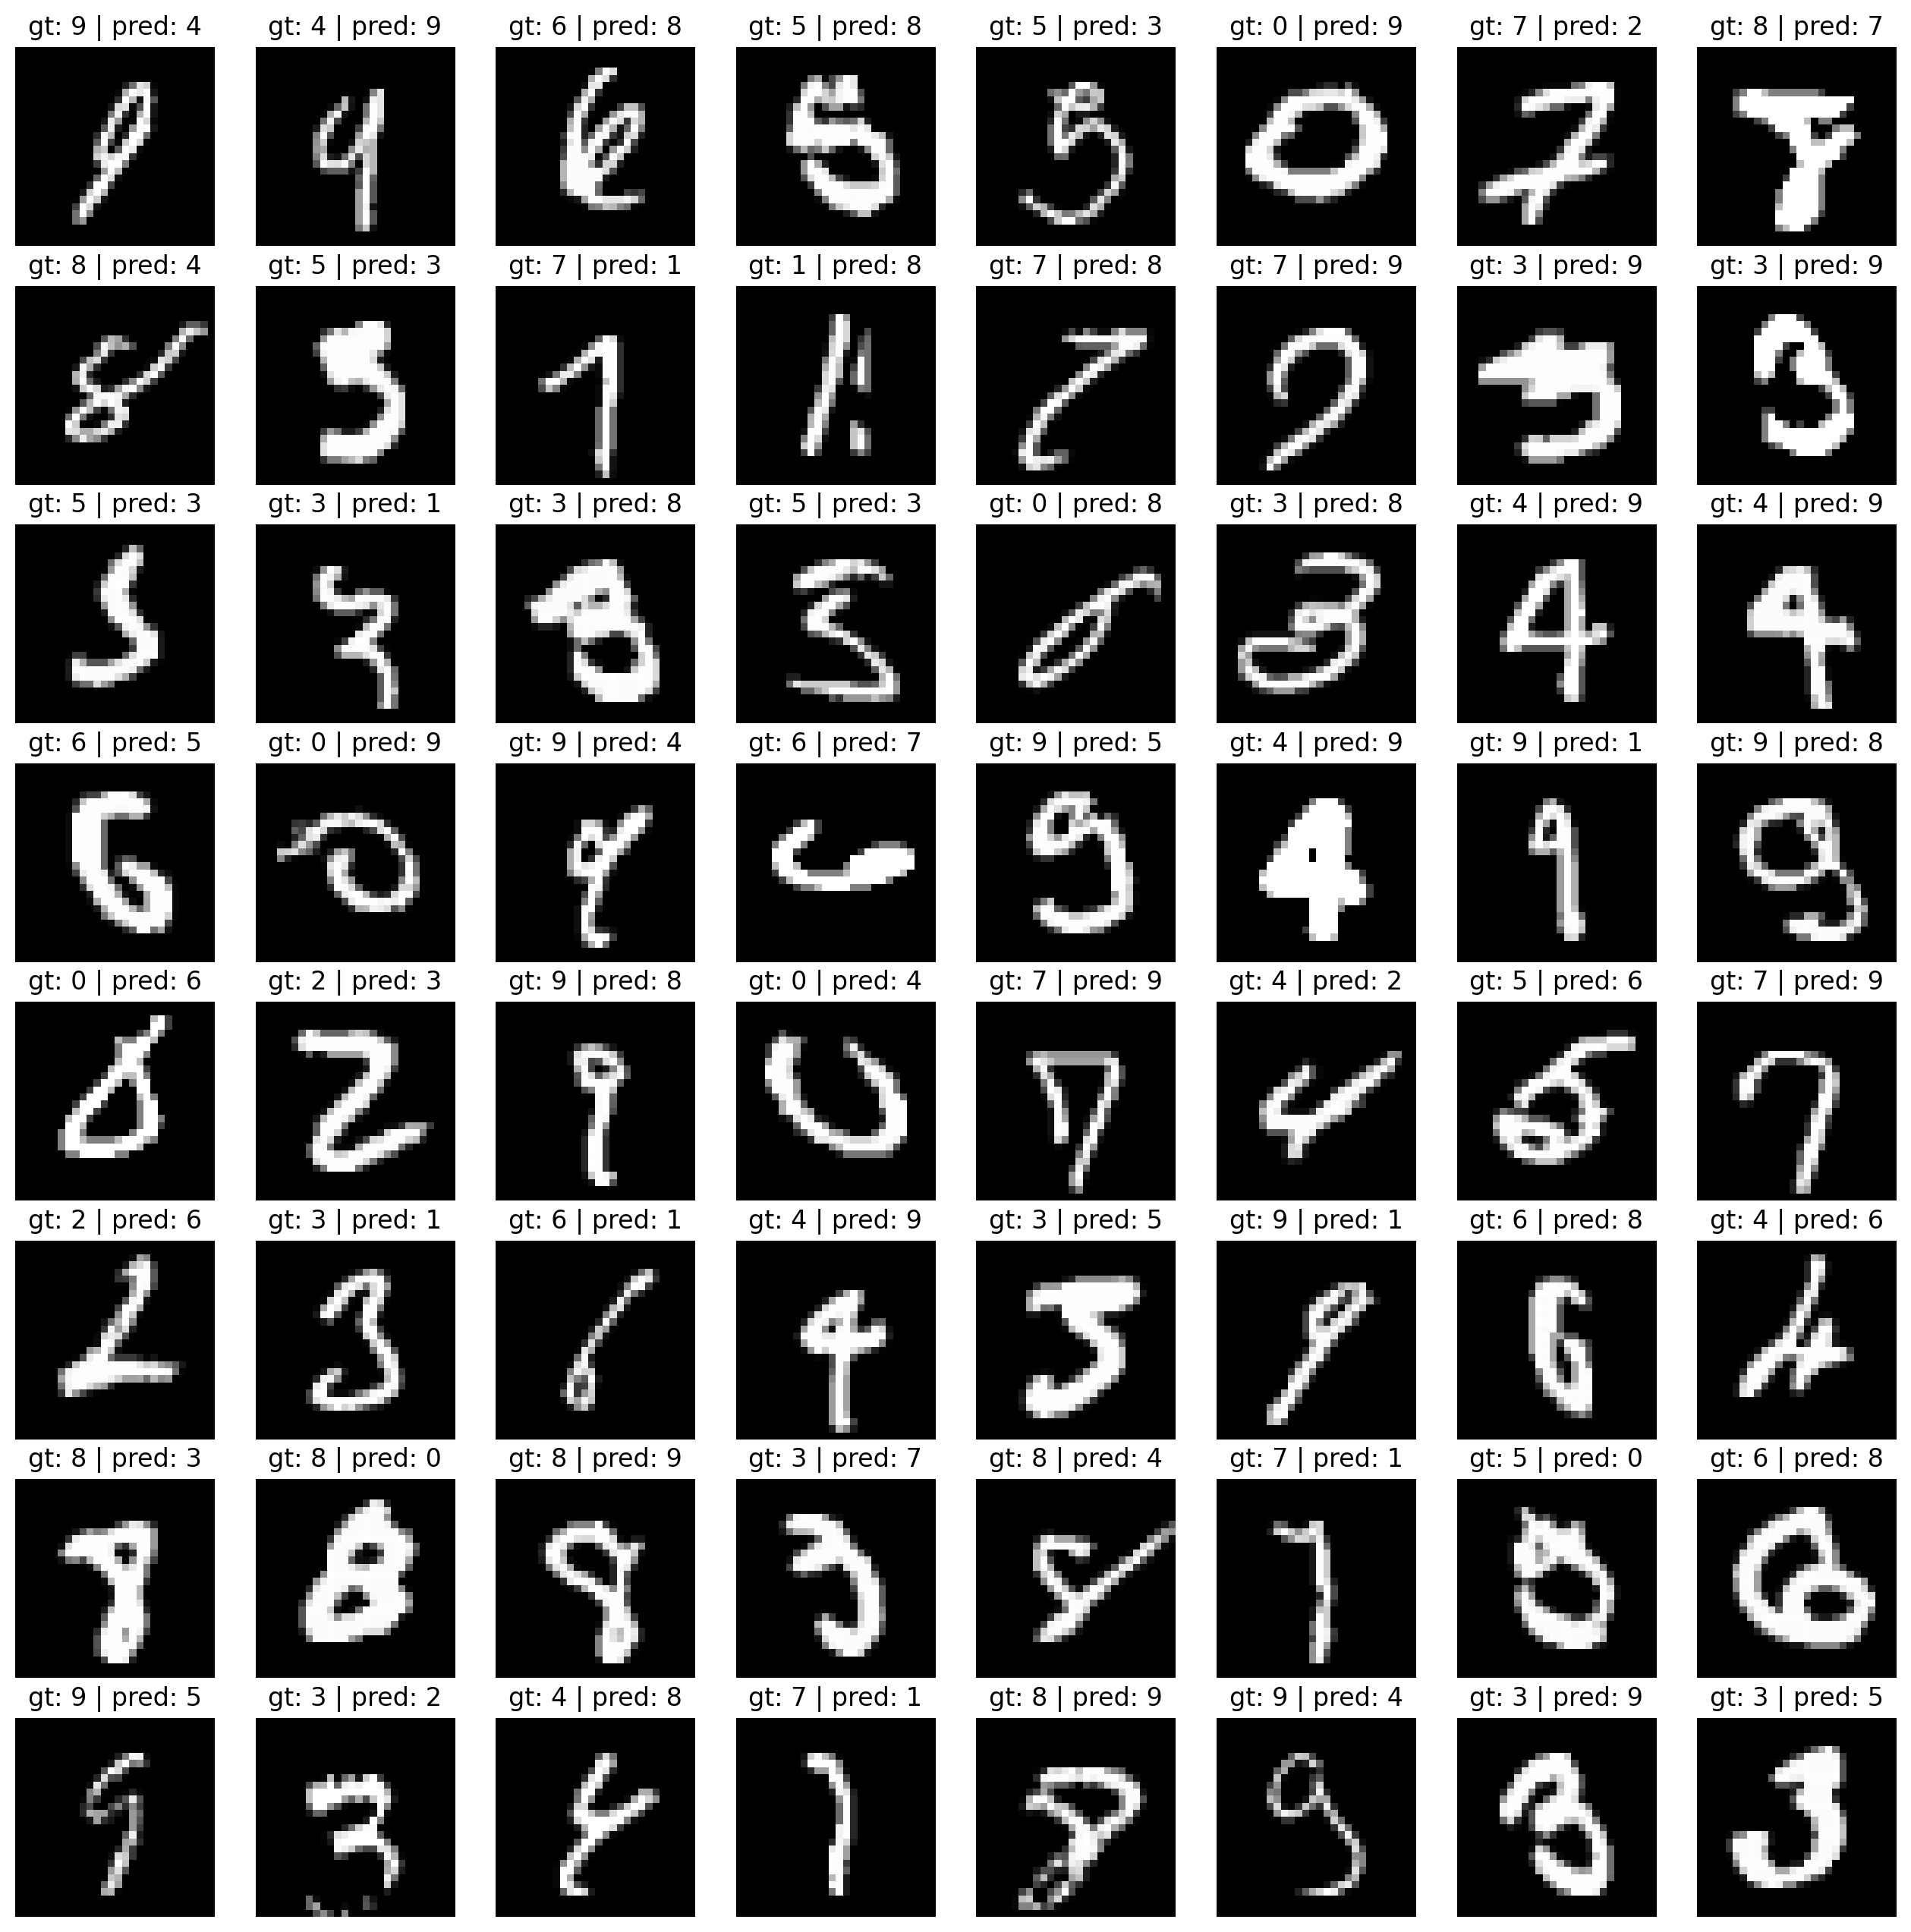

In [150]:
show_images_with_captions(sample_images, sample_captions)

## Итоги

* Узнали, какие есть базовые сущности в Pytorch для обучения нейросетей
* Реализовали собственные классы датасета и модели
* Написали собственную функции активации и даже `backward()` для нее

В следующий раз: 
* Свертки и сверточные сети